# Code Overview
## 1. Data Upload and preparation
## 2. Exploratory Data Analysis (EDA)
## 3. Modeling
## 4. Internal validation
## 5. External vadliation & visualization
## 6. Summary of parameter
## 7. SHAP(SHapley Additive exPlanations) analysis
## 8. Supplemental Material - Distribution of Internal, external dataset

# #1 Dataset Upload and Preparation

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [ ]:
# Import required libraries
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
uploaded = files.upload()

Saving Training_dataset_205patients.xlsx to Training_dataset_205patients.xlsx


In [ ]:
df_training = pd.read_excel('Training_dataset_205patients.xlsx')

In [ ]:
df_training.head()

Gender  Age     BW  Height        BMI  ICU   WBC   RBC   HCT    Hb  ...  \
0       1   60  49.78   158.9  19.715468    0  11.1  3.33  31.9  11.4  ...   
1       1   46  70.00   174.0  23.120624    0   5.2  3.95  37.9  13.1  ...   
2       1   83  66.50   162.1  25.307871    0   4.5  2.96  27.2   9.1  ...   
3       1   33  90.00   172.0  30.421850    1  13.9  5.30  43.3  15.3  ...   
4       0   48  70.00   150.0  31.111111    1   9.9  3.25  31.5  10.8  ...   

   ACEi  Fusosemide  Diuretics  Vasopressors  LAB  AG  TZP  FLC  FQ  \
0     0           0          0             0    0   0    1    0   0   
1     0           0          0             0    0   0    0    0   0   
2     0           0          0             0    0   0    1    0   0   
3     0           0          0             0    0   0    0    0   1   
4     0           0          0             0    0   0    0    0   0   

   Initial VCM_daily_dose  
0                    2500  
1                    2100  
2                    3000  
3                    2000  
4                    2000  

[5 rows x 30 columns]

In [ ]:
print("Missing values in each column:")
print(df_training.isnull().sum())

Missing values in each column:
Gender                    0
Age                       0
BW                        0
Height                    0
BMI                       0
ICU                       0
WBC                       0
RBC                       0
HCT                       0
Hb                        0
PLT                       0
CRP                       0
eGFR                      0
BUN                       0
Scr                       0
Albumin                   0
TP                        0
UA                        0
NSAIDs                    0
ARB                       0
ACEi                      0
Fusosemide                0
Diuretics                 0
Vasopressors              0
LAB                       0
AG                        0
TZP                       0
FLC                       0
FQ                        0
Initial VCM_daily_dose    0
dtype: int64


In [ ]:
target_column = 'Initial VCM_daily_dose'
X = df_training.drop(columns=[target_column])
y = df_training[target_column]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# #2 Exploratory Data Analysis (EDA)

- 2.1 Description of training dataset
- 2.2 Distributions of all variables

In [ ]:
print("Dataset Info:")
X_train.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 66 to 102
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gender        164 non-null    int64  
 1   Age           164 non-null    int64  
 2   BW            164 non-null    float64
 3   Height        164 non-null    float64
 4   BMI           164 non-null    float64
 5   ICU           164 non-null    int64  
 6   WBC           164 non-null    float64
 7   RBC           164 non-null    float64
 8   HCT           164 non-null    float64
 9   Hb            164 non-null    float64
 10  PLT           164 non-null    int64  
 11  CRP           164 non-null    float64
 12  eGFR          164 non-null    float64
 13  BUN           164 non-null    float64
 14  Scr           164 non-null    float64
 15  Albumin       164 non-null    float64
 16  TP            164 non-null    float64
 17  UA            164 non-null    float64
 18  NSAIDs        164 no

In [ ]:
print("\nDataset Description (Numerical Features):")
print(X_train.describe())


Dataset Description (Numerical Features):
           Gender         Age          BW      Height         BMI         ICU  \
count  164.000000  164.000000  164.000000  164.000000  164.000000  164.000000   
mean     0.554878   65.524390   61.639756  163.067073   23.098243    0.225610   
std      0.498501   16.257684   13.211329    9.027294    4.023249    0.419263   
min      0.000000   21.000000   33.000000  135.000000   14.302382    0.000000   
25%      0.000000   58.000000   52.525000  158.000000   20.525683    0.000000   
50%      1.000000   69.000000   60.000000  163.300000   23.049273    0.000000   
75%      1.000000   79.000000   69.775000  170.000000   25.636917    0.000000   
max      1.000000   92.000000  113.300000  183.000000   35.759374    1.000000   

              WBC         RBC         HCT          Hb  ...         ARB   ACEi  \
count  164.000000  164.000000  164.000000  164.000000  ...  164.000000  164.0   
mean    11.592683    3.348415   30.500000   10.178659  ...    0.1

In [ ]:
print(f"\nTraining Features Shape: {X_train.shape}")
print(f"Training Target Shape: {y_train.shape}")


Training Features Shape: (164, 29)
Training Target Shape: (164,)


## #2-2 Distributions of all variables

<ipython-input-14-54ffc4ef84d9>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_training[variable], ax=axs[row, col], order=[0, 1], palette=['dodgerblue', 'orange'])
<ipython-input-14-54ffc4ef84d9>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_training[variable], ax=axs[row, col], order=[0, 1], palette=['dodgerblue', 'orange'])
<ipython-input-14-54ffc4ef84d9>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_training[variable], ax=axs[row, col], order=[0, 1], palette=['dodgerblue', 'orange'])
<ipython-input-14-54ff

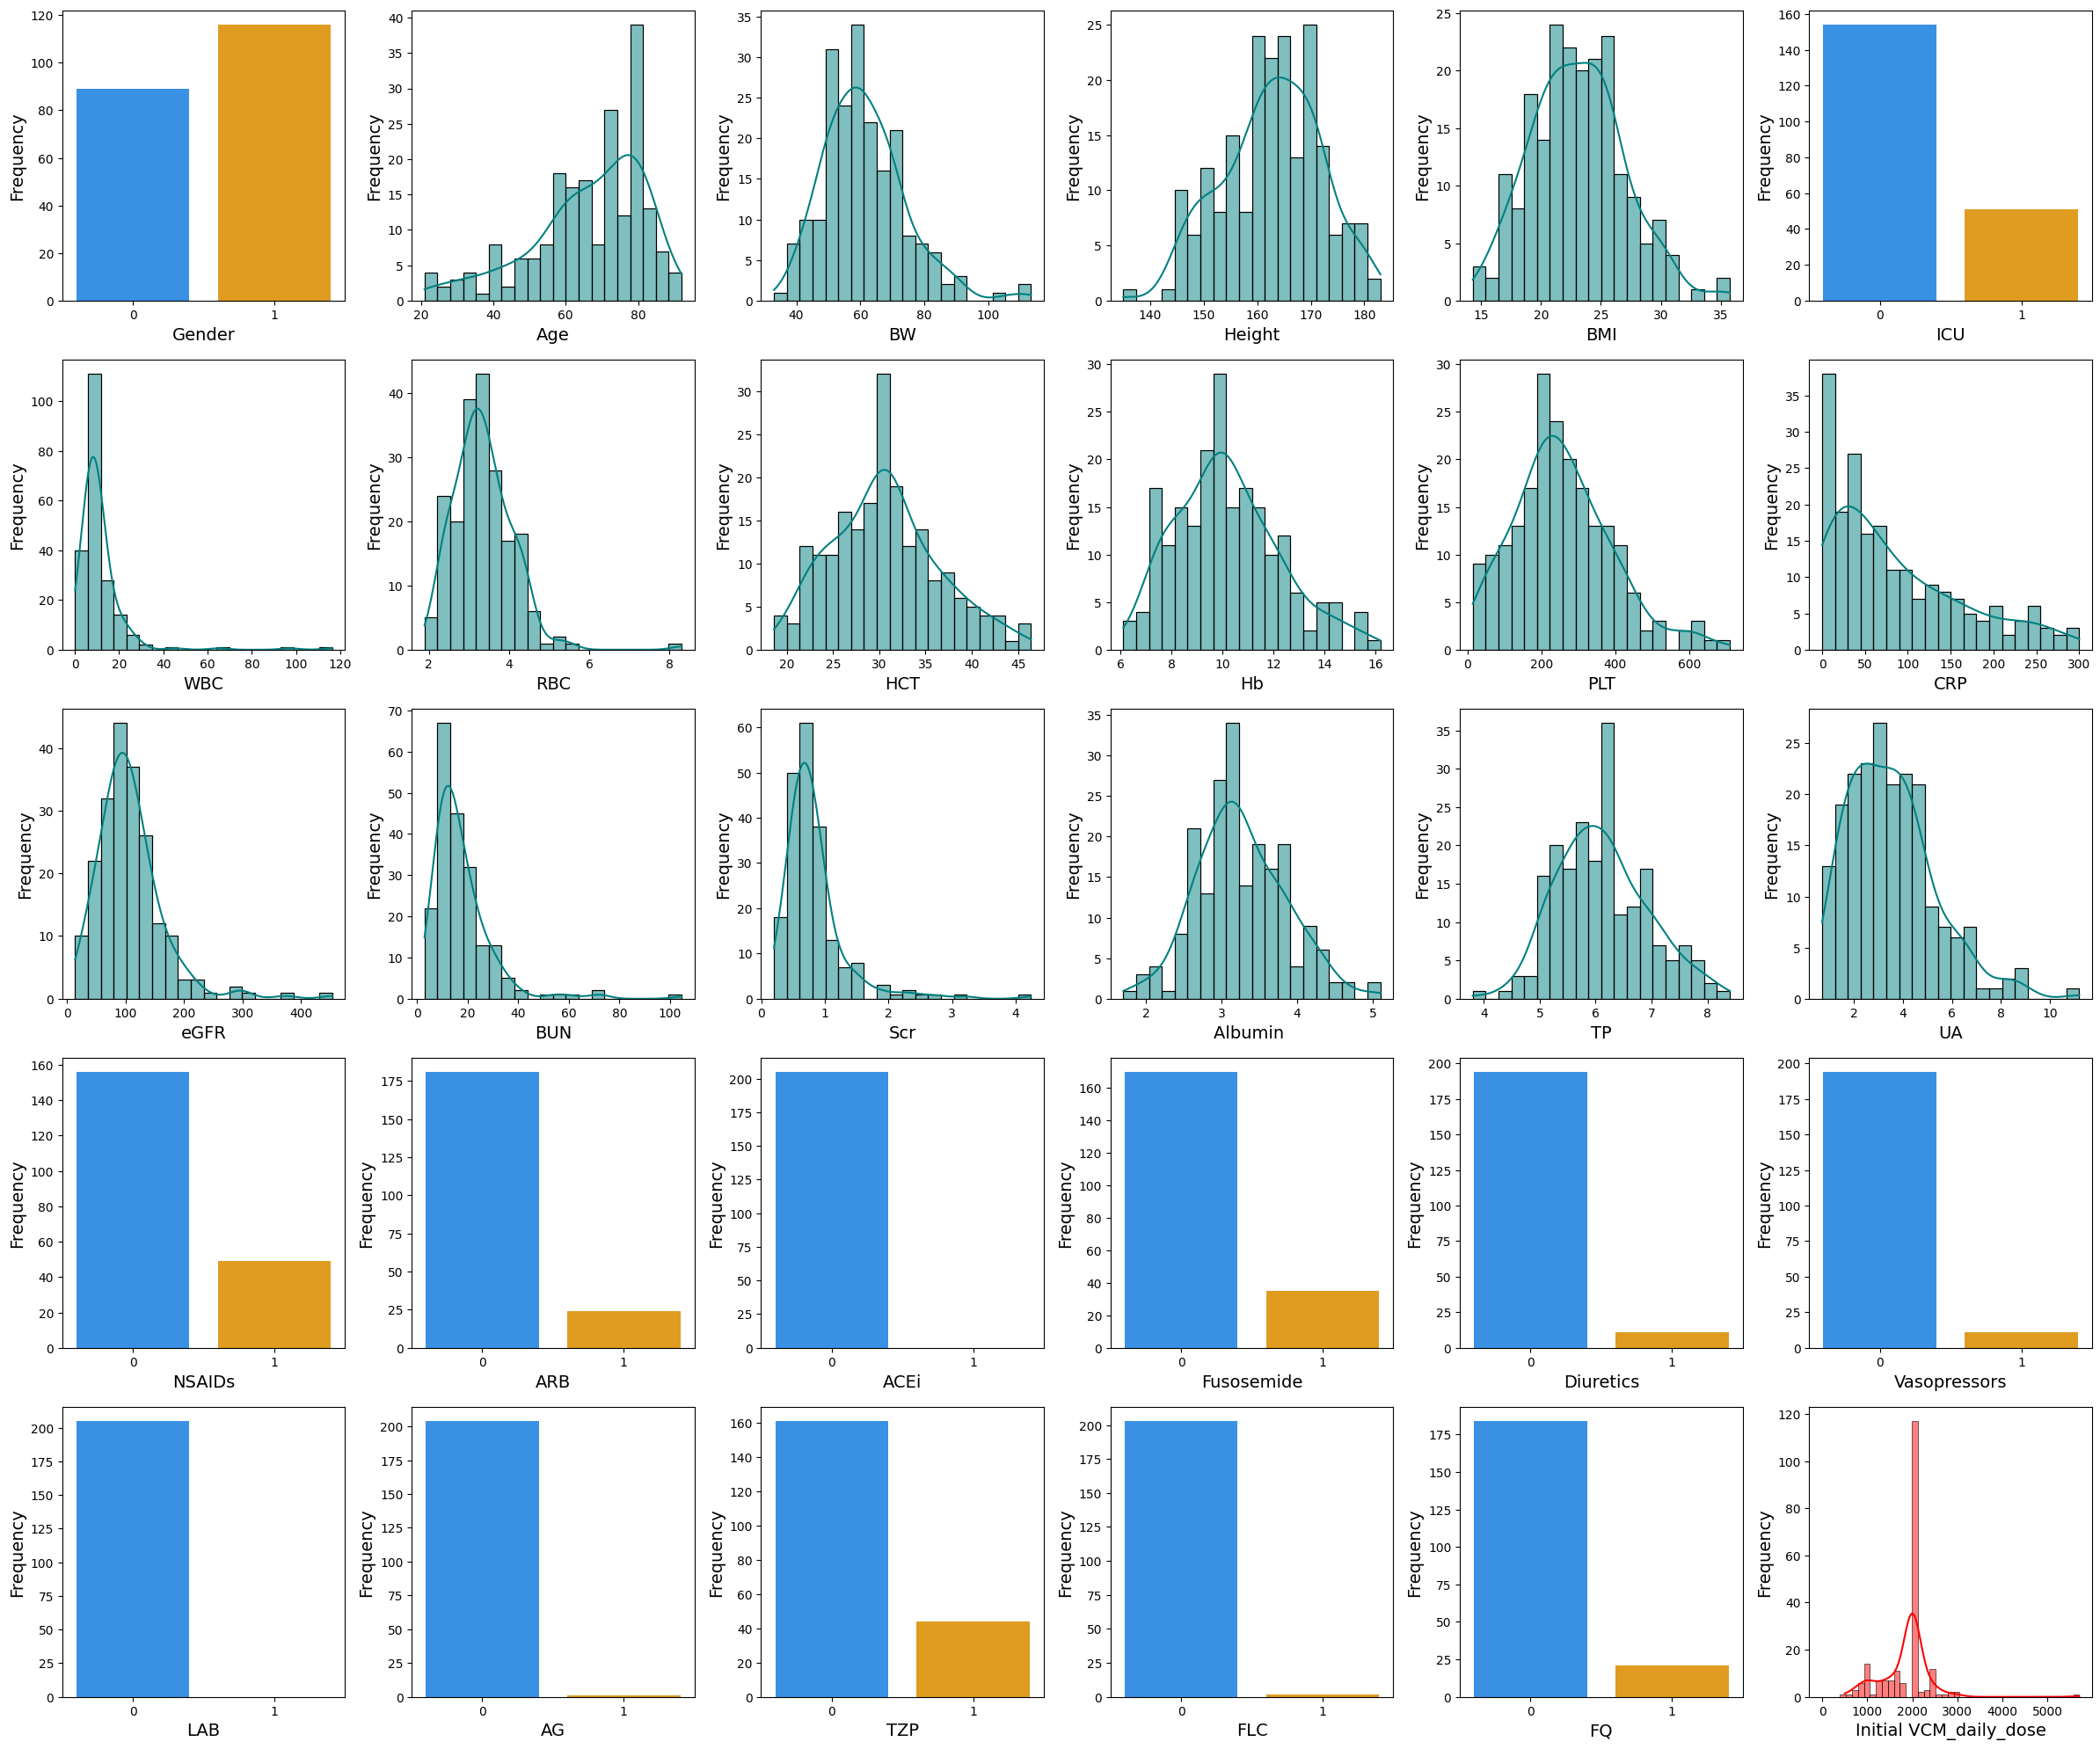

In [ ]:
all_variables = df_training.columns
target_variable = 'Initial VCM_daily_dose'

# List of columns with binary values
binary_columns = ['Gender', 'ICU', 'NSAIDs', 'ARB', 'ACEi', 'Fusosemide', 'Diuretics', 'Vasopressors', 'LAB', 'AG', 'TZP', 'FLC', 'FQ']

# Validate binary columns
binary_columns = [col for col in binary_columns if col in df_training.columns]

# Determine rows and columns dynamically
num_cols = 6
num_rows = (len(all_variables) + num_cols - 1) // num_cols  # Ceiling division

# Setting up the figure size dynamically
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
sns.set_palette('colorblind')

for i, variable in enumerate(all_variables):
    row = i // num_cols
    col = i % num_cols
    if variable == target_variable:
        sns.histplot(df_training[variable], kde=True, color='red', ax=axs[row, col], binrange=(0, df_training[variable].max()))
    elif variable in binary_columns:
        sns.countplot(x=df_training[variable], ax=axs[row, col], order=[0, 1], palette=['dodgerblue', 'orange'])
    else:
        sns.histplot(df_training[variable], kde=True, ax=axs[row, col], bins=20, color='teal')
    axs[row, col].set_xlabel(variable, fontsize=14)
    axs[row, col].set_ylabel('Frequency', fontsize=14)

# Remove extra plots
for j in range(len(all_variables), num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()

# Save the figure with Distributions of all variables (300 dpi)
plt.savefig('Distributions of all variables.png', dpi=300)


In [ ]:
# Download the figure
files.download('Distributions of all variables.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# #3 Modeling

In [ ]:
# Define a function for training and tuning models
def train_and_evaluate_model(models, X_train, y_train, X_test, y_test, kfold):
    results = {}
    for model_name, (model, param_dist) in models.items():
        print(f"Training and tuning {model_name}...")

        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=50,  # Number of parameter settings sampled
            cv=kfold,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
        cv_rmse = np.sqrt(-random_search.best_score_)

        results[model_name] = {
            "Best Model": best_model,
            "Best Params": best_params,
            "CV RMSE": cv_rmse
        }

        print(f"{model_name} completed. Best Params: {best_params}, CV RMSE: {cv_rmse:.4f}")

    return results


In [ ]:
# Define models and parameters for RandomizedSearchCV
models = {
    "Random Forest": (RandomForestRegressor(random_state=42), {
        "n_estimators": [100, 200, 300, 400],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }),
    "XGBoost": (XGBRegressor(random_state=42), {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 6, 9]
    }),
    "LightGBM": (LGBMRegressor(random_state=42), {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [-1, 10, 20]
    }),
    "CatBoost": (CatBoostRegressor(random_state=42, verbose=0), {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2]
    }),
    "Extra Trees": (ExtraTreesRegressor(random_state=42), {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10]
    }),
    "SVR": (SVR(), {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    })
}

In [ ]:
# Train models
tuned_results = train_and_evaluate_model(models, X_train, y_train, X_test, y_test, kfold)

Training and tuning Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Forest completed. Best Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}, CV RMSE: 362.5504
Training and tuning XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


XGBoost completed. Best Params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}, CV RMSE: 374.7682
Training and tuning LightGBM...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 164, number of used features: 21
[LightGBM] [Info] Start training from score 1848.384146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CatBoost completed. Best Params: {'n_estimators': 300, 'learning_rate': 0.01}, CV RMSE: 375.3850
Training and tuning Extra Trees...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Extra Trees completed. Best Params: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 20}, CV RMSE: 384.8266
Training and tuning SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SVR completed. Best Params: {'kernel': 'linear', 'gamma': 'scale', 'C': 10}, CV RMSE: 436.1442


In [ ]:
# Evaluate on test set
test_results = {}
for model_name, info in tuned_results.items():
    best_model = info["Best Model"]
    predictions = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    test_results[model_name] = {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
    }

In [ ]:
# Convert test results to DataFrame for display
test_results_df = pd.DataFrame(test_results).T
print("\nModel Performance Comparison on Test Set:")
print(test_results_df)


Model Performance Comparison on Test Set:
                     RMSE         MAE        R2
Random Forest  676.383059  343.247247  0.211656
XGBoost        686.240729  341.495233  0.188510
LightGBM       681.394603  332.986927  0.199931
CatBoost       694.654391  341.535716  0.168489
Extra Trees    685.635768  350.945640  0.189940
SVR            717.634631  379.763708  0.112564


In [ ]:
# Voting Ensemble
print("\nTraining Voting Ensemble...")
voting_regressor = VotingRegressor(estimators=[
    ("Random Forest", tuned_results["Random Forest"]["Best Model"]),
    ("XGBoost", tuned_results["XGBoost"]["Best Model"]),
    ("LightGBM", tuned_results["LightGBM"]["Best Model"])
])
voting_regressor.fit(X_train, y_train)



Training Voting Ensemble...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 164, number of used features: 21
[LightGBM] [Info] Start training from score 1848.384146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

VotingRegressor(estimators=[('Random Forest',
                             RandomForestRegressor(max_depth=10,
                                                   min_samples_leaf=4,
                                                   min_samples_split=10,
                                                   n_estimators=200,
                                                   random_state=42)),
                            ('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=Fal...
                                          learning_rate=0.01, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=200,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('LightGBM',
                             LGBMRegressor(learning_rate=0.01, n_estimators=200,
                                           random_state=42))])

In [ ]:
# Evaluate Voting Ensemble
voting_predictions = voting_regressor.predict(X_test)
voting_rmse = np.sqrt(mean_squared_error(y_test, voting_predictions))
voting_mae = mean_absolute_error(y_test, voting_predictions)
voting_r2 = r2_score(y_test, voting_predictions)


In [ ]:
print(f"Voting Ensemble Model - RMSE: {voting_rmse:.4f}, MAE: {voting_mae:.4f}, R2: {voting_r2:.4f}")


Voting Ensemble Model - RMSE: 679.4507, MAE: 333.9897, R2: 0.2045


In [ ]:
# Add Voting Ensemble results to test_results_df
test_results_df.loc["Voting Ensemble"] = [voting_rmse, voting_mae, voting_r2]
print("\nUpdated Model Performance Comparison:")
print(test_results_df)


Updated Model Performance Comparison:
                       RMSE         MAE        R2
Random Forest    676.383059  343.247247  0.211656
XGBoost          686.240729  341.495233  0.188510
LightGBM         681.394603  332.986927  0.199931
CatBoost         694.654391  341.535716  0.168489
Extra Trees      685.635768  350.945640  0.189940
SVR              717.634631  379.763708  0.112564
Voting Ensemble  679.450734  333.989736  0.204489


# #4 Internal Validation

In [ ]:
uploaded = files.upload()

Saving Internal_validation_dataset_44patients.xlsx to Internal_validation_dataset_44patients.xlsx


In [ ]:
df_internal = pd.read_excel('Internal_validation_dataset_44patients.xlsx')

In [ ]:
df_internal.describe()

Gender        Age          BW      Height        BMI        ICU  \
count  44.000000  44.000000   44.000000   44.000000  44.000000  44.000000   
mean    0.522727  63.340909   66.490909  162.640909  24.997346   0.204545   
std     0.505258  17.234286   15.418953    9.144787   4.619760   0.408032   
min     0.000000  18.000000   45.000000  144.000000  17.501600   0.000000   
25%     0.000000  55.750000   55.900000  153.000000  22.273183   0.000000   
50%     1.000000  65.000000   62.050000  163.400000  23.688076   0.000000   
75%     1.000000  74.250000   70.725000  170.125000  27.548543   0.000000   
max     1.000000  86.000000  104.000000  181.600000  39.260790   1.000000   

             WBC        RBC        HCT         Hb  ...  ACEi  Fusosemide  \
count  44.000000  44.000000  44.000000  44.000000  ...  44.0   44.000000   
mean    9.225000   3.725455  33.313636  11.025000  ...   0.0    0.113636   
std     5.646449   0.826701   7.111360   2.448552  ...   0.0    0.321038   
min     0.600000   1.970000  18.600000   5.900000  ...   0.0    0.000000   
25%     4.900000   3.052500  28.250000   9.400000  ...   0.0    0.000000   
50%     7.550000   3.735000  33.550000  10.850000  ...   0.0    0.000000   
75%    12.475000   4.407500  38.350000  12.675000  ...   0.0    0.000000   
max    23.400000   5.270000  45.900000  15.500000  ...   0.0    1.000000   

       Diuretics  Vasopressors        LAB    AG        TZP   FLC         FQ  \
count       44.0     44.000000  44.000000  44.0  44.000000  44.0  44.000000   
mean         0.0      0.090909   0.022727   0.0   0.250000   0.0   0.068182   
std          0.0      0.290803   0.150756   0.0   0.438019   0.0   0.254972   
min          0.0      0.000000   0.000000   0.0   0.000000   0.0   0.000000   
25%          0.0      0.000000   0.000000   0.0   0.000000   0.0   0.000000   
50%          0.0      0.000000   0.000000   0.0   0.000000   0.0   0.000000   
75%          0.0      0.000000   0.000000   0.0   0.250000   0.0   0.000000   
max          0.0      1.000000   1.000000   0.0   1.000000   0.0   1.000000   

       Initial VCM_daily_dose  
count               44.000000  
mean              2104.545455  
std                881.186976  
min                750.000000  
25%               1600.000000  
50%               2000.000000  
75%               2500.000000  
max               6000.000000  

[8 rows x 30 columns]

In [ ]:
X_internal = df_internal.drop('Initial VCM_daily_dose', axis=1)
y_internal = df_internal['Initial VCM_daily_dose']

In [ ]:
# Define function to calculate 20% threshold accuracy
def calculate_accuracy_within_threshold(y_true, y_pred, threshold=0.2):
    lower_bound = y_true * (1 - threshold)
    upper_bound = y_true * (1 + threshold)
    within_threshold = ((y_pred >= lower_bound) & (y_pred <= upper_bound)).sum()
    accuracy = within_threshold / len(y_true)
    return accuracy

In [ ]:
# Define function to calculate Adjusted R²
def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - n_features - 1))
    return adjusted_r2


In [ ]:
internal_results = {}

In [ ]:
# Evaluate each model
for model_name, info in tuned_results.items():
    model = info["Best Model"]
    print(f"Evaluating {model_name} on the internal validation set...")

    # Make predictions
    predictions = model.predict(X_internal)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_internal, predictions))
    mae = mean_absolute_error(y_internal, predictions)
    r2 = r2_score(y_internal, predictions)
    accuracy = calculate_accuracy_within_threshold(y_internal, predictions)

    # Store results
    internal_results[model_name] = {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "20% Accuracy": accuracy
    }
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, 20% Accuracy: {accuracy:.4%}")


Evaluating Random Forest on the internal validation set...
Random Forest - RMSE: 858.9765, MAE: 518.5660, R2: 0.0277, 20% Accuracy: 56.8182%
Evaluating XGBoost on the internal validation set...
XGBoost - RMSE: 875.0246, MAE: 512.2553, R2: -0.0090, 20% Accuracy: 56.8182%
Evaluating LightGBM on the internal validation set...
LightGBM - RMSE: 872.2935, MAE: 523.9822, R2: -0.0027, 20% Accuracy: 52.2727%
Evaluating CatBoost on the internal validation set...
CatBoost - RMSE: 876.6898, MAE: 520.9411, R2: -0.0128, 20% Accuracy: 50.0000%
Evaluating Extra Trees on the internal validation set...
Extra Trees - RMSE: 883.8761, MAE: 531.3358, R2: -0.0295, 20% Accuracy: 54.5455%
Evaluating SVR on the internal validation set...
SVR - RMSE: 843.6674, MAE: 527.9628, R2: 0.0620, 20% Accuracy: 50.0000%


In [ ]:
# Evaluate Voting Ensemble
print("Evaluating Voting Ensemble on the internal validation set...")
voting_predictions = voting_regressor.predict(X_internal)

Evaluating Voting Ensemble on the internal validation set...


In [ ]:
# Calculate metrics for Voting Ensemble
voting_rmse = np.sqrt(mean_squared_error(y_internal, voting_predictions))
voting_mae = mean_absolute_error(y_internal, voting_predictions)
voting_r2 = r2_score(y_internal, voting_predictions)
voting_adjusted_r2 = adjusted_r2_score(y_internal, voting_predictions, X_internal.shape[1])
voting_accuracy = calculate_accuracy_within_threshold(y_internal, voting_predictions)


In [ ]:
# Store Voting Ensemble results
internal_results["Voting Ensemble"] = {
    "RMSE": voting_rmse,
    "MAE": voting_mae,
    "R2": voting_r2,
    "20% Accuracy": voting_accuracy
}
print(f"Voting Ensemble - RMSE: {voting_rmse:.4f}, MAE: {voting_mae:.4f}, R2: {voting_r2:.4f}, 20% Accuracy: {voting_accuracy:.4%}")


Voting Ensemble - RMSE: 867.6927, MAE: 516.1028, R2: 0.0078, 20% Accuracy: 54.5455%


In [ ]:
# Convert results to DataFrame
internal_results_df = pd.DataFrame(internal_results).T
print("\nInternal Validation Results:")
print(internal_results_df)



Internal Validation Results:
                       RMSE         MAE        R2  20% Accuracy
Random Forest    858.976472  518.566010  0.027677      0.568182
XGBoost          875.024599  512.255307 -0.008994      0.568182
LightGBM         872.293455  523.982153 -0.002705      0.522727
CatBoost         876.689801  520.941112 -0.012838      0.500000
Extra Trees      883.876127  531.335788 -0.029511      0.545455
SVR              843.667358  527.962808  0.062026      0.500000
Voting Ensemble  867.692724  516.102778  0.007844      0.545455


# #5 External validation & Visualization

In [ ]:
# Uploading 'External_validation_dataset_35patients.xlsx'
uploaded = files.upload()

Saving External_validation_dataset_35patients.xlsx to External_validation_dataset_35patients.xlsx


In [ ]:
df_external = pd.read_excel('External_validation_dataset_35patients.xlsx')

In [ ]:
df_external.describe()

Gender        Age          BW      Height        BMI        ICU  \
count  35.00000  35.000000   35.000000   35.000000  35.000000  35.000000   
mean    0.80000  68.771429   63.471429  165.411429  22.900652   0.628571   
std     0.40584  18.594885   18.215630    9.689587   4.556124   0.490241   
min     0.00000  16.000000   40.000000  145.000000  15.241579   0.000000   
25%     1.00000  64.500000   50.000000  160.000000  18.638126   0.000000   
50%     1.00000  74.000000   58.200000  166.000000  22.857143   1.000000   
75%     1.00000  80.000000   70.500000  171.000000  25.399980   1.000000   
max     1.00000  92.000000  120.000000  185.000000  35.062089   1.000000   

             WBC        RBC        HCT         Hb  ...  ACEi  Fusosemide  \
count  35.000000  35.000000  35.000000  35.000000  ...  35.0   35.000000   
mean   12.494286   3.270857  29.582857  10.102857  ...   0.0    0.114286   
std     8.897582   0.632750   5.234135   1.761264  ...   0.0    0.322803   
min     0.280000   2.210000  21.300000   7.400000  ...   0.0    0.000000   
25%     7.935000   2.830000  25.950000   8.850000  ...   0.0    0.000000   
50%     9.430000   3.160000  28.600000   9.700000  ...   0.0    0.000000   
75%    15.250000   3.840000  34.750000  11.750000  ...   0.0    0.000000   
max    50.430000   4.570000  39.500000  13.500000  ...   0.0    1.000000   

       Diuretics  Vasopressors   LAB    AG       TZP   FLC         FQ  \
count       35.0     35.000000  35.0  35.0  35.00000  35.0  35.000000   
mean         0.0      0.285714   0.0   0.0   0.20000   0.0   0.085714   
std          0.0      0.458349   0.0   0.0   0.40584   0.0   0.284029   
min          0.0      0.000000   0.0   0.0   0.00000   0.0   0.000000   
25%          0.0      0.000000   0.0   0.0   0.00000   0.0   0.000000   
50%          0.0      0.000000   0.0   0.0   0.00000   0.0   0.000000   
75%          0.0      1.000000   0.0   0.0   0.00000   0.0   0.000000   
max          0.0      1.000000   0.0   0.0   1.00000   0.0   1.000000   

       Initial VCM_daily_dose  
count               35.000000  
mean              1882.857143  
std                698.100665  
min                600.000000  
25%               1875.000000  
50%               2000.000000  
75%               2000.000000  
max               4800.000000  

[8 rows x 30 columns]

In [ ]:
X_external = df_external.drop('Initial VCM_daily_dose', axis=1)
y_external = df_external['Initial VCM_daily_dose']

In [ ]:
# External validation results dictionary
external_results = {}

In [ ]:
# Evaluate each model
for model_name, info in tuned_results.items():
    model = info["Best Model"]
    print(f"Evaluating {model_name} on the external validation set...")

    # Make predictions
    predictions = model.predict(X_external)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_external, predictions))
    mae = mean_absolute_error(y_external, predictions)
    r2 = r2_score(y_external, predictions)
    adjusted_r2 = adjusted_r2_score(y_external, predictions, X_external.shape[1])
    accuracy = calculate_accuracy_within_threshold(y_external, predictions)

    # Store results
    external_results[model_name] = {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "20% Accuracy": accuracy
    }
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, 20% Accuracy: {accuracy:.4%}")


Evaluating Random Forest on the external validation set...
Random Forest - RMSE: 608.2747, MAE: 338.6005, R2: 0.2185, 20% Accuracy: 74.2857%
Evaluating XGBoost on the external validation set...
XGBoost - RMSE: 601.6538, MAE: 312.4817, R2: 0.2354, 20% Accuracy: 74.2857%
Evaluating LightGBM on the external validation set...
LightGBM - RMSE: 618.7133, MAE: 338.9381, R2: 0.1914, 20% Accuracy: 71.4286%
Evaluating CatBoost on the external validation set...
CatBoost - RMSE: 614.7441, MAE: 330.7283, R2: 0.2017, 20% Accuracy: 68.5714%
Evaluating Extra Trees on the external validation set...
Extra Trees - RMSE: 615.4089, MAE: 344.8034, R2: 0.2000, 20% Accuracy: 65.7143%
Evaluating SVR on the external validation set...
SVR - RMSE: 609.4569, MAE: 343.1257, R2: 0.2154, 20% Accuracy: 71.4286%


In [ ]:
# Evaluate Voting Ensemble
print("Evaluating Voting Ensemble on the external validation set...")
voting_predictions = voting_regressor.predict(X_external)


Evaluating Voting Ensemble on the external validation set...


In [ ]:
# Calculate metrics for Voting Ensemble
voting_rmse = np.sqrt(mean_squared_error(y_external, voting_predictions))
voting_mae = mean_absolute_error(y_external, voting_predictions)
voting_r2 = r2_score(y_external, voting_predictions)
voting_accuracy = calculate_accuracy_within_threshold(y_external, voting_predictions)

In [ ]:
# Store Voting Ensemble results
external_results["Voting Ensemble"] = {
    "RMSE": voting_rmse,
    "MAE": voting_mae,
    "R2": voting_r2,
    "20% Accuracy": voting_accuracy
}
print(f"Voting Ensemble - RMSE: {voting_rmse:.4f}, MAE: {voting_mae:.4f}, R2: {voting_r2:.4f}, 20% Accuracy: {voting_accuracy:.4%}")


Voting Ensemble - RMSE: 607.9979, MAE: 325.8138, R2: 0.2192, 20% Accuracy: 74.2857%


In [ ]:
# Convert results to a DataFrame
external_results_df = pd.DataFrame(external_results).T
print("\nExternal Validation Results:")
print(external_results_df)



External Validation Results:
                       RMSE         MAE        R2  20% Accuracy
Random Forest    608.274716  338.600496  0.218458      0.742857
XGBoost          601.653796  312.481742  0.235379      0.742857
LightGBM         618.713306  338.938109  0.191403      0.714286
CatBoost         614.744117  330.728288  0.201745      0.685714
Extra Trees      615.408921  344.803411  0.200017      0.657143
SVR              609.456880  343.125716  0.215417      0.714286
Voting Ensemble  607.997921  325.813781  0.219169      0.742857


In [ ]:
def plot_prediction_error_with_threshold(y_true, y_pred, model_name, ax):
    ax.scatter(y_true, y_pred - y_true, alpha=0.5)
    ax.set_title(f'{model_name}', fontsize=16)  # Only model name as title
    ax.set_xlabel('True Values', fontsize=14)
    ax.set_ylabel('Prediction Error', fontsize=14)
    ax.axhline(y=0, color='r', linestyle='-')  # Zero error line
    # Adding 20% error threshold lines
    ax.axhline(y=0.2 * np.mean(y_true), color='r', linestyle='--', label='±20% Threshold')
    ax.axhline(y=-0.2 * np.mean(y_true), color='r', linestyle='--')
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

In [ ]:
def visualize_internal_validation(y_internal, internal_predictions, save_path="internal_validation_plots.png"):
    num_models = len(internal_predictions)
    rows = (num_models // 3) + (num_models % 3 > 0)  # Calculate rows for 3 columns

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows), dpi=300)  # Adjust figure size
    axs = axs.flatten()  # Flatten the axes array for easy iteration

    for i, (model_name, predictions) in enumerate(internal_predictions.items()):
        plot_prediction_error_with_threshold(y_internal, predictions, f"{model_name} - Internal Validation", axs[i])

    # Hide unused subplots if models < 9
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Visualize for external validation
def visualize_external_validation(y_external, external_predictions, save_path="external_validation_plots.png"):
    num_models = len(external_predictions)
    rows = (num_models // 3) + (num_models % 3 > 0)  # Calculate rows for 3 columns

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows), dpi=300)  # Adjust figure size
    axs = axs.flatten()  # Flatten the axes array for easy iteration

    for i, (model_name, predictions) in enumerate(external_predictions.items()):
        plot_prediction_error_with_threshold(y_external, predictions, f"{model_name} - External Validation", axs[i])

    # Hide unused subplots if models < 9
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [ ]:
internal_predictions = {}

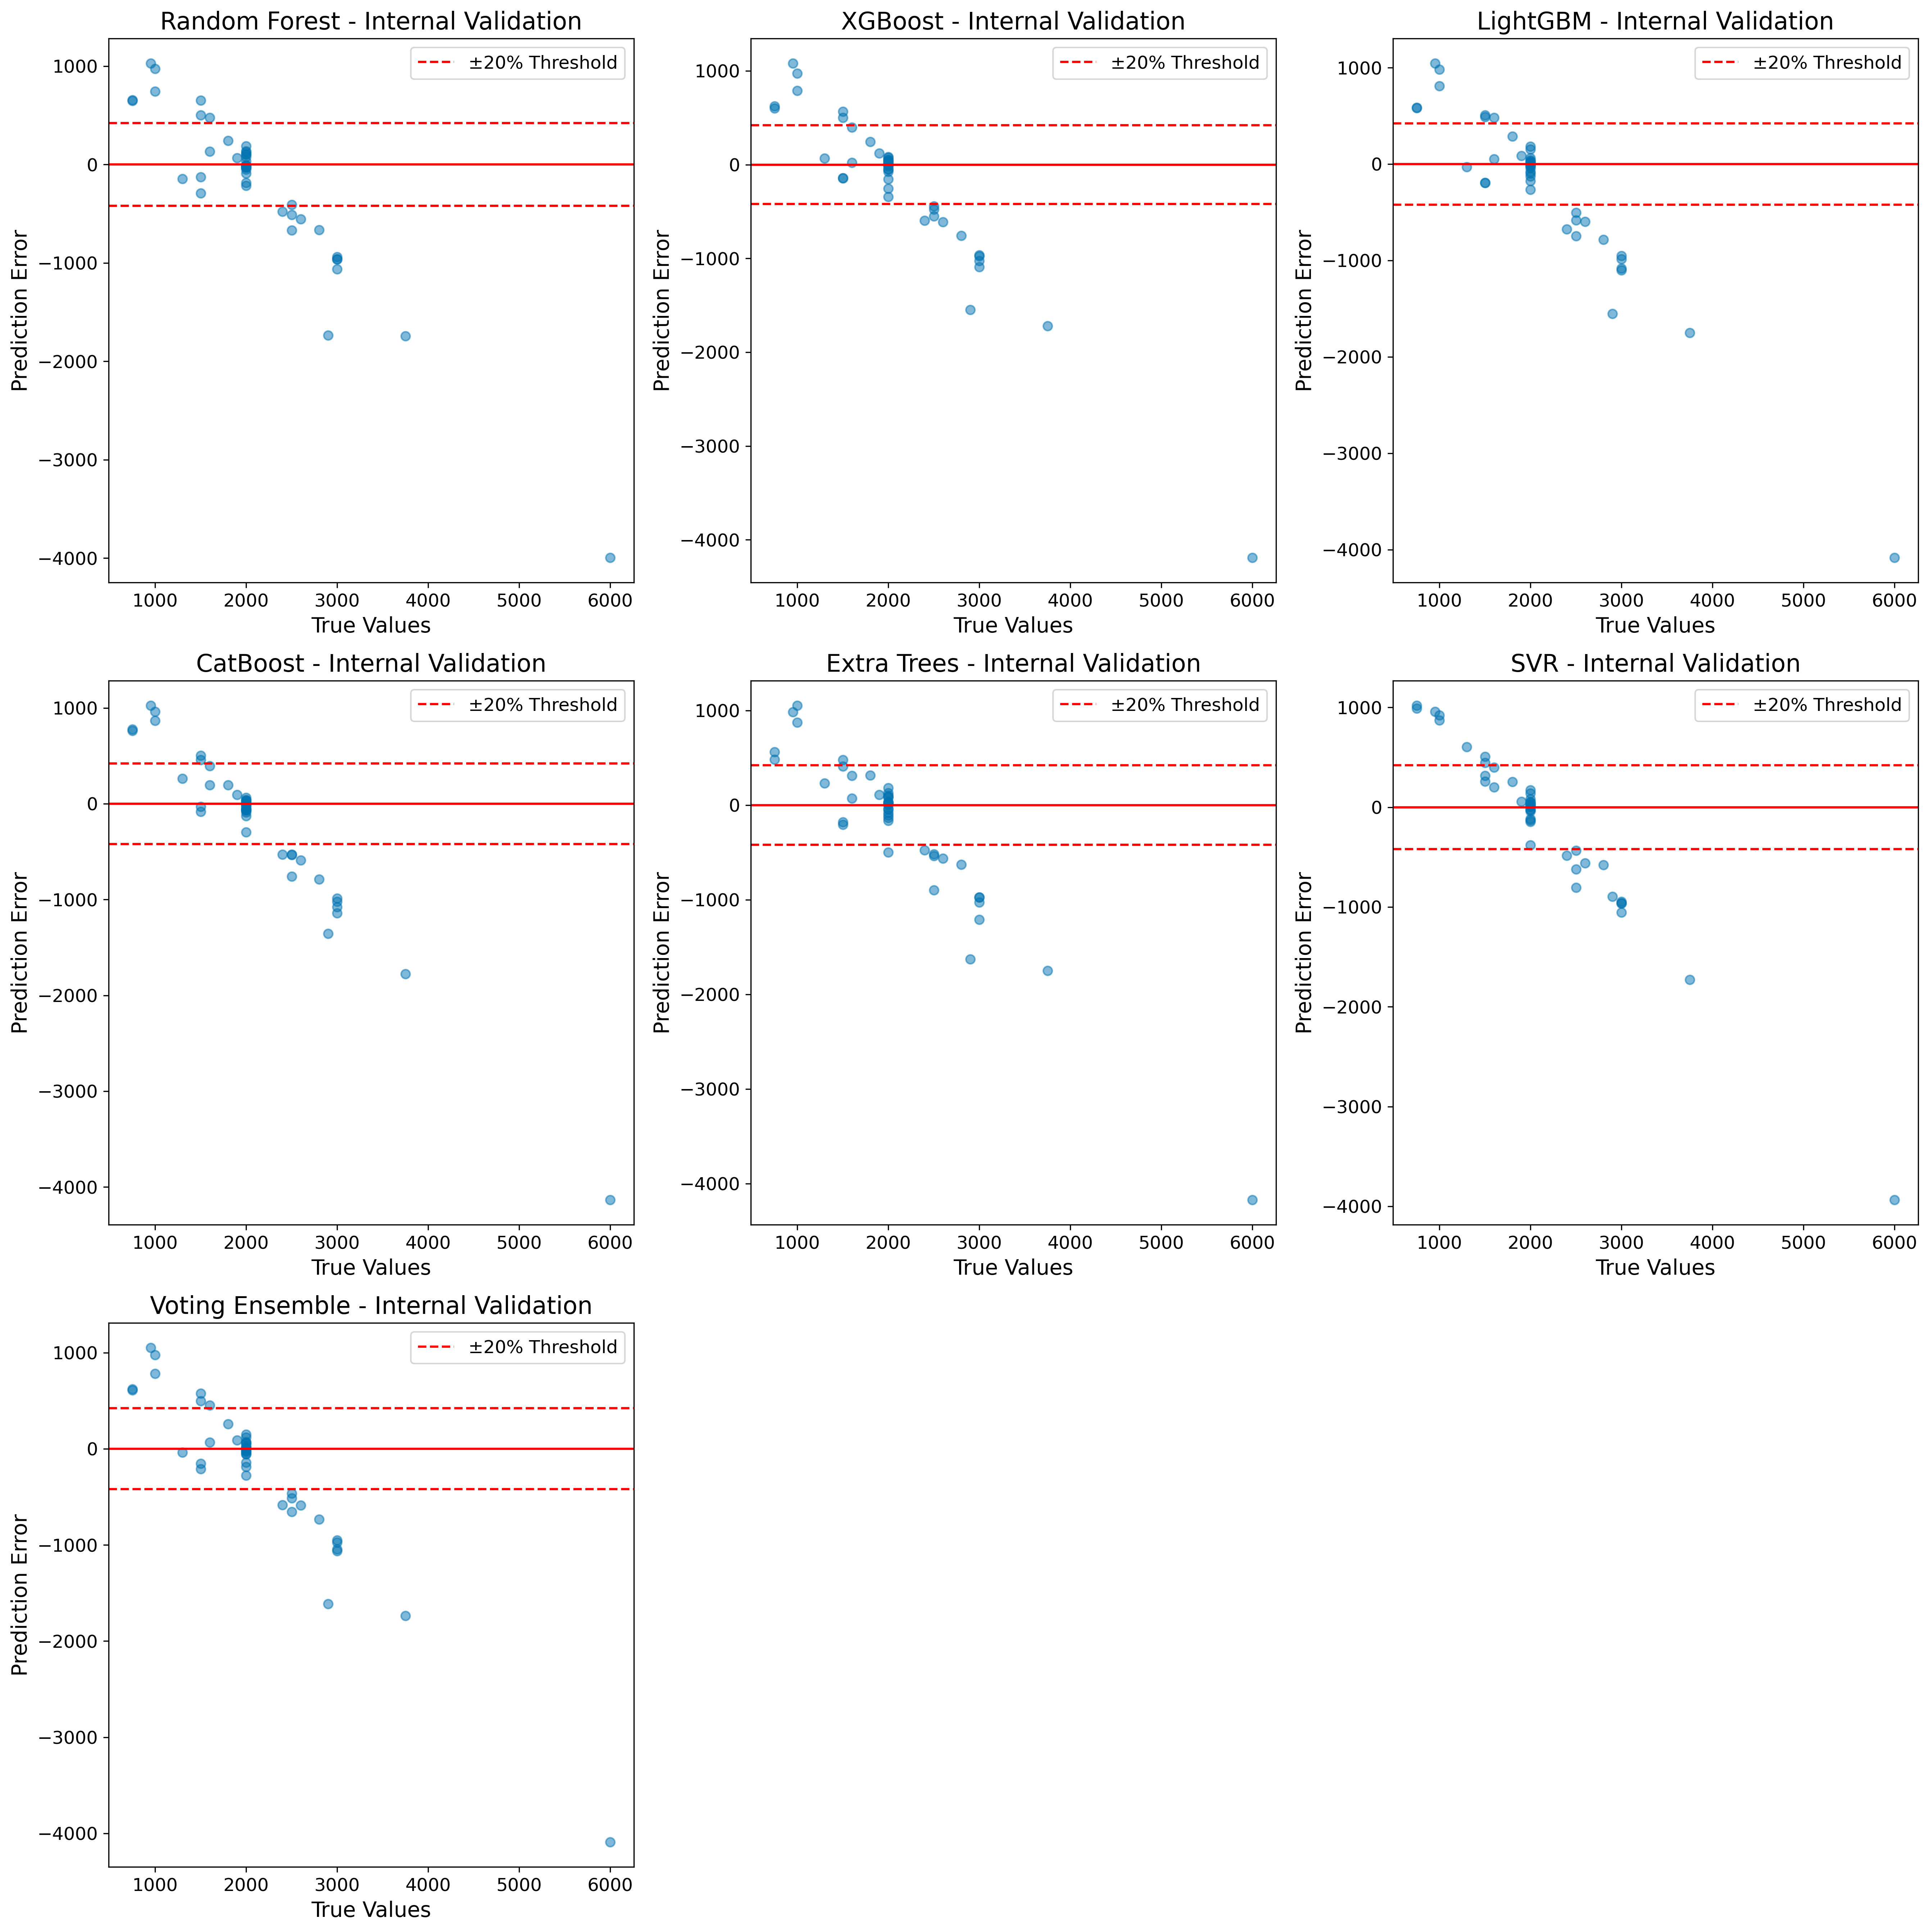

In [ ]:
# 이미 계산된 Internal Validation 결과에서 예측값을 딕셔너리로 저장
internal_predictions = {
    "Random Forest": tuned_results["Random Forest"]["Best Model"].predict(X_internal),
    "XGBoost": tuned_results["XGBoost"]["Best Model"].predict(X_internal),
    "LightGBM": tuned_results["LightGBM"]["Best Model"].predict(X_internal),
    "CatBoost": tuned_results["CatBoost"]["Best Model"].predict(X_internal),
    "Extra Trees": tuned_results["Extra Trees"]["Best Model"].predict(X_internal),
    "SVR": tuned_results["SVR"]["Best Model"].predict(X_internal),
    "Voting Ensemble": voting_regressor.predict(X_internal)
}

# Internal Validation 시각화
visualize_internal_validation(
    y_internal=y_internal,
    internal_predictions=internal_predictions,
    save_path="internal_validation_results.png"
)


In [ ]:
# 이미지 다운로드
files.download("internal_validation_results.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

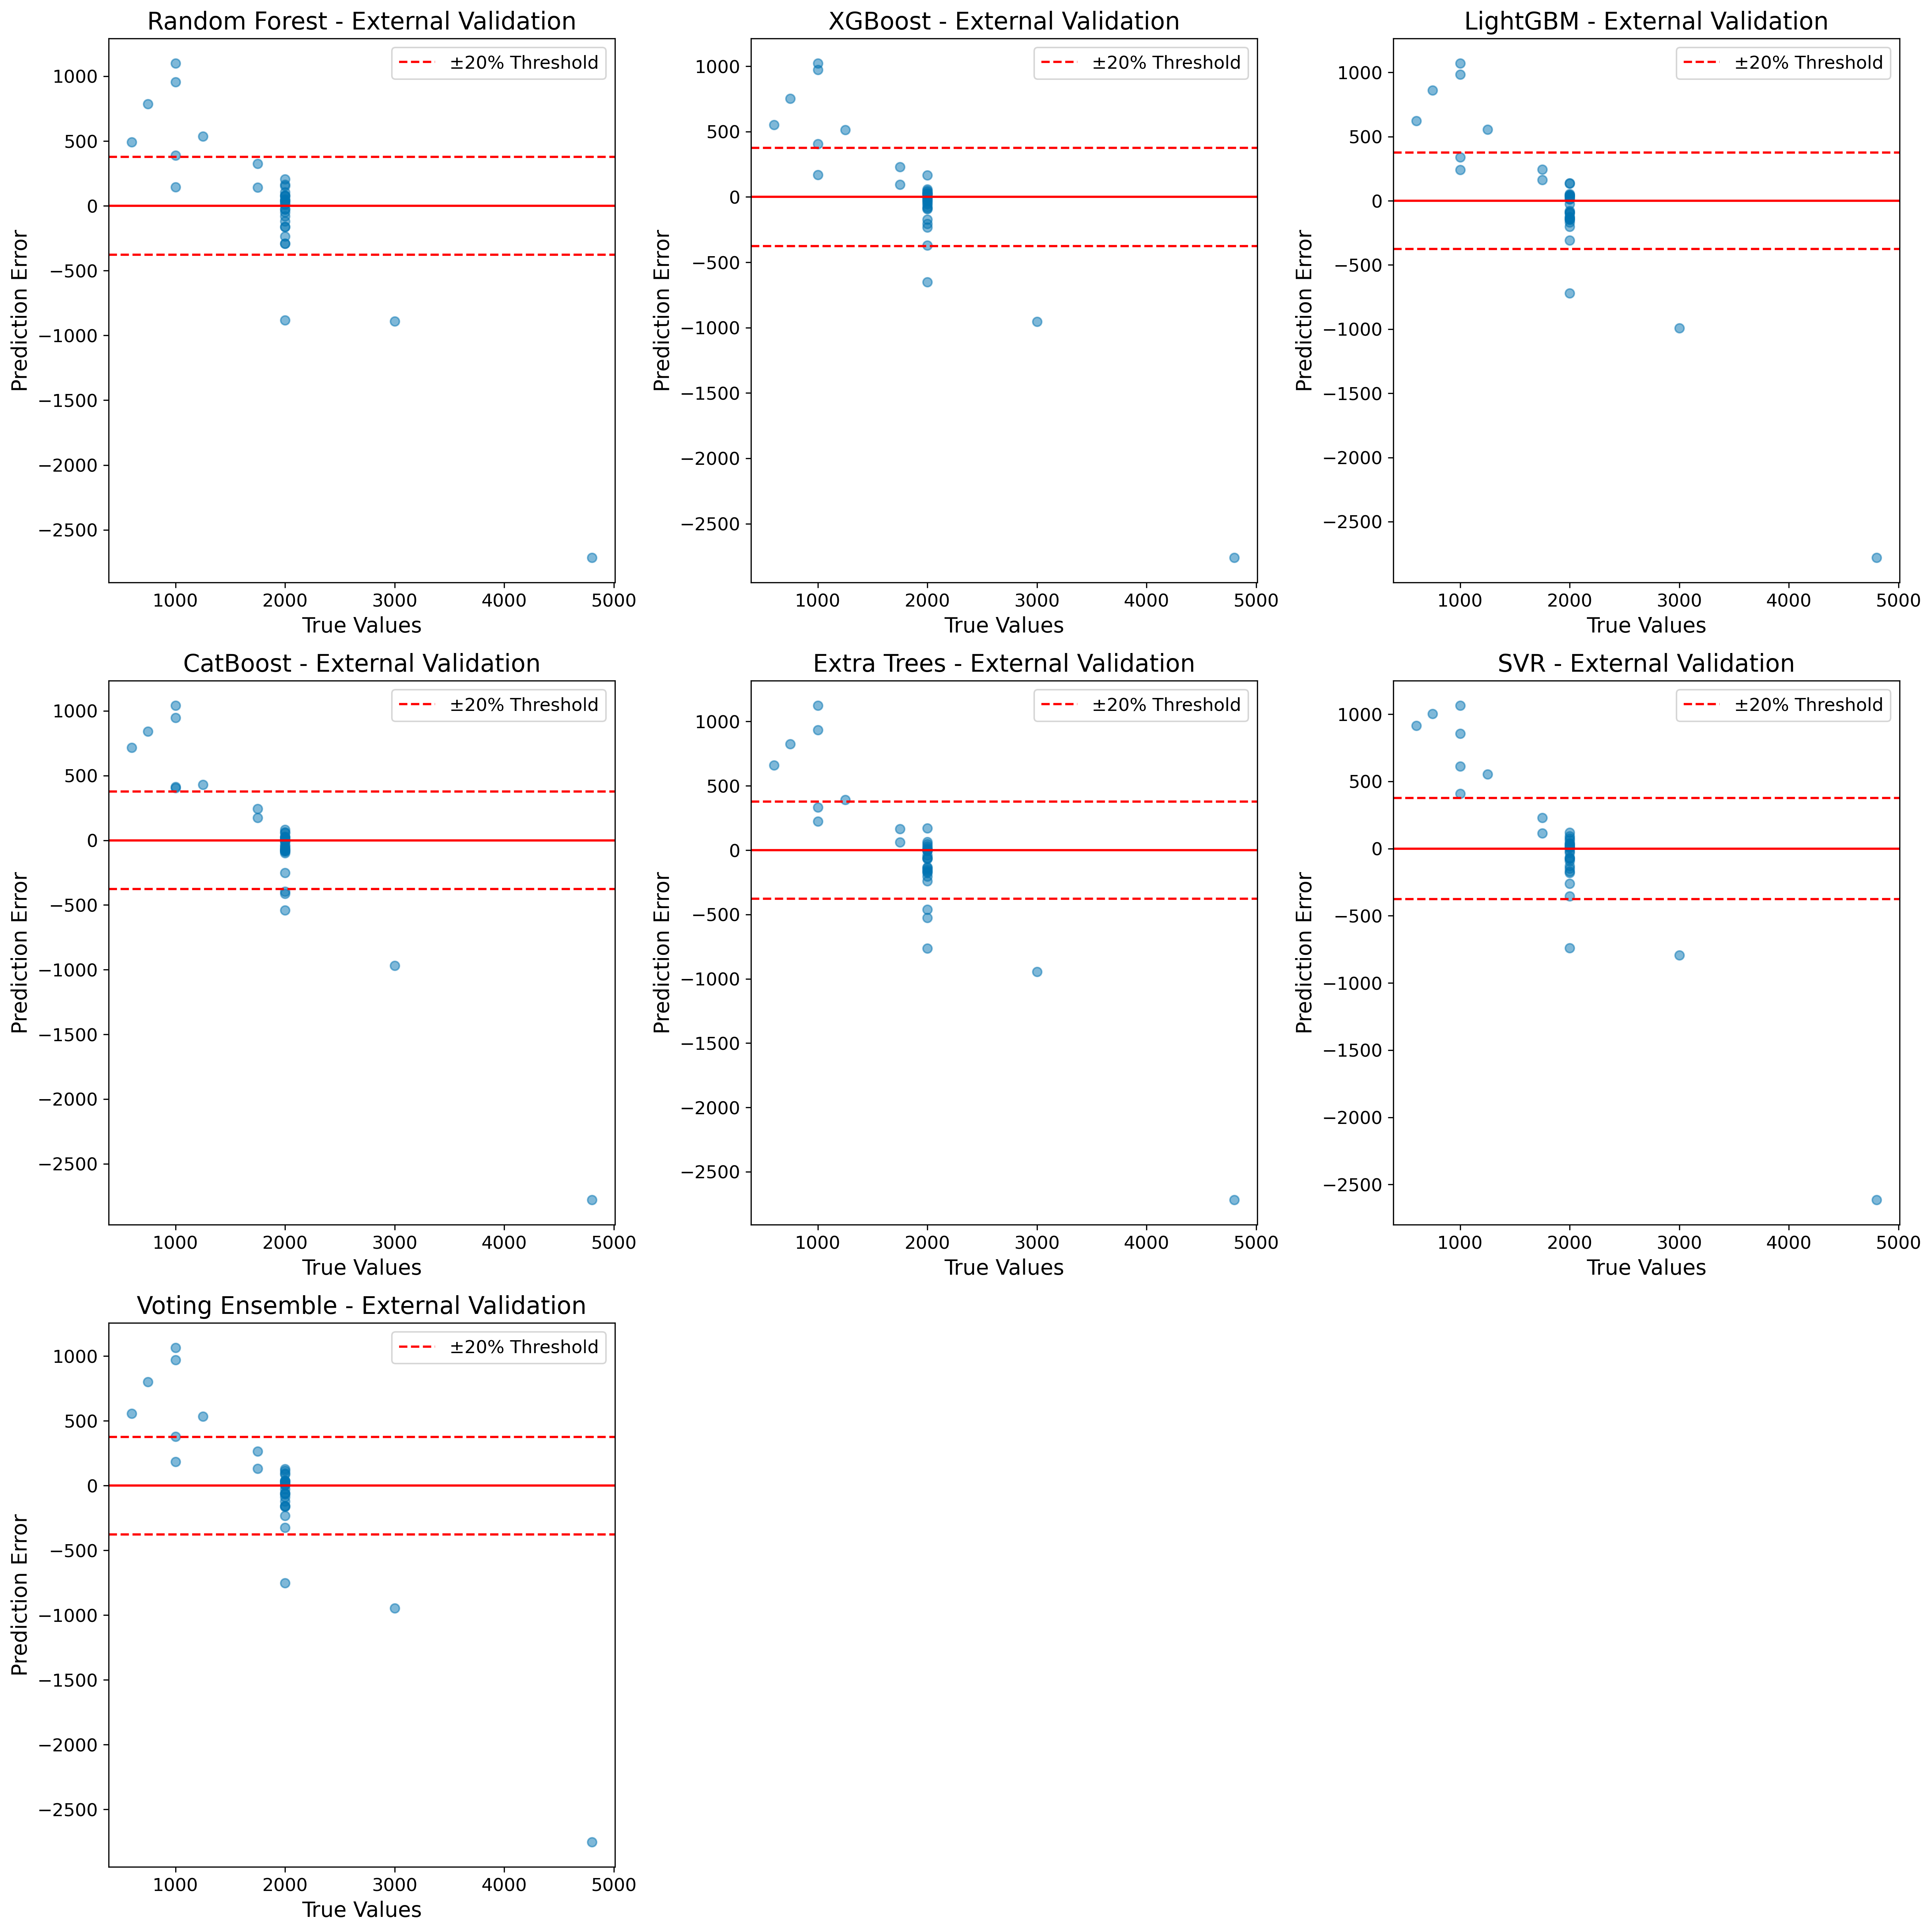

In [ ]:
# 이미 계산된 External Validation 결과에서 예측값을 딕셔너리로 저장
external_predictions = {
    "Random Forest": tuned_results["Random Forest"]["Best Model"].predict(X_external),
    "XGBoost": tuned_results["XGBoost"]["Best Model"].predict(X_external),
    "LightGBM": tuned_results["LightGBM"]["Best Model"].predict(X_external),
    "CatBoost": tuned_results["CatBoost"]["Best Model"].predict(X_external),
    "Extra Trees": tuned_results["Extra Trees"]["Best Model"].predict(X_external),
    "SVR": tuned_results["SVR"]["Best Model"].predict(X_external),
    "Voting Ensemble": voting_regressor.predict(X_external)
}

# External Validation 시각화
visualize_external_validation(
    y_external=y_external,
    external_predictions=external_predictions,
    save_path="external_validation_results.png"
)


In [ ]:
files.download("external_validation_results.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

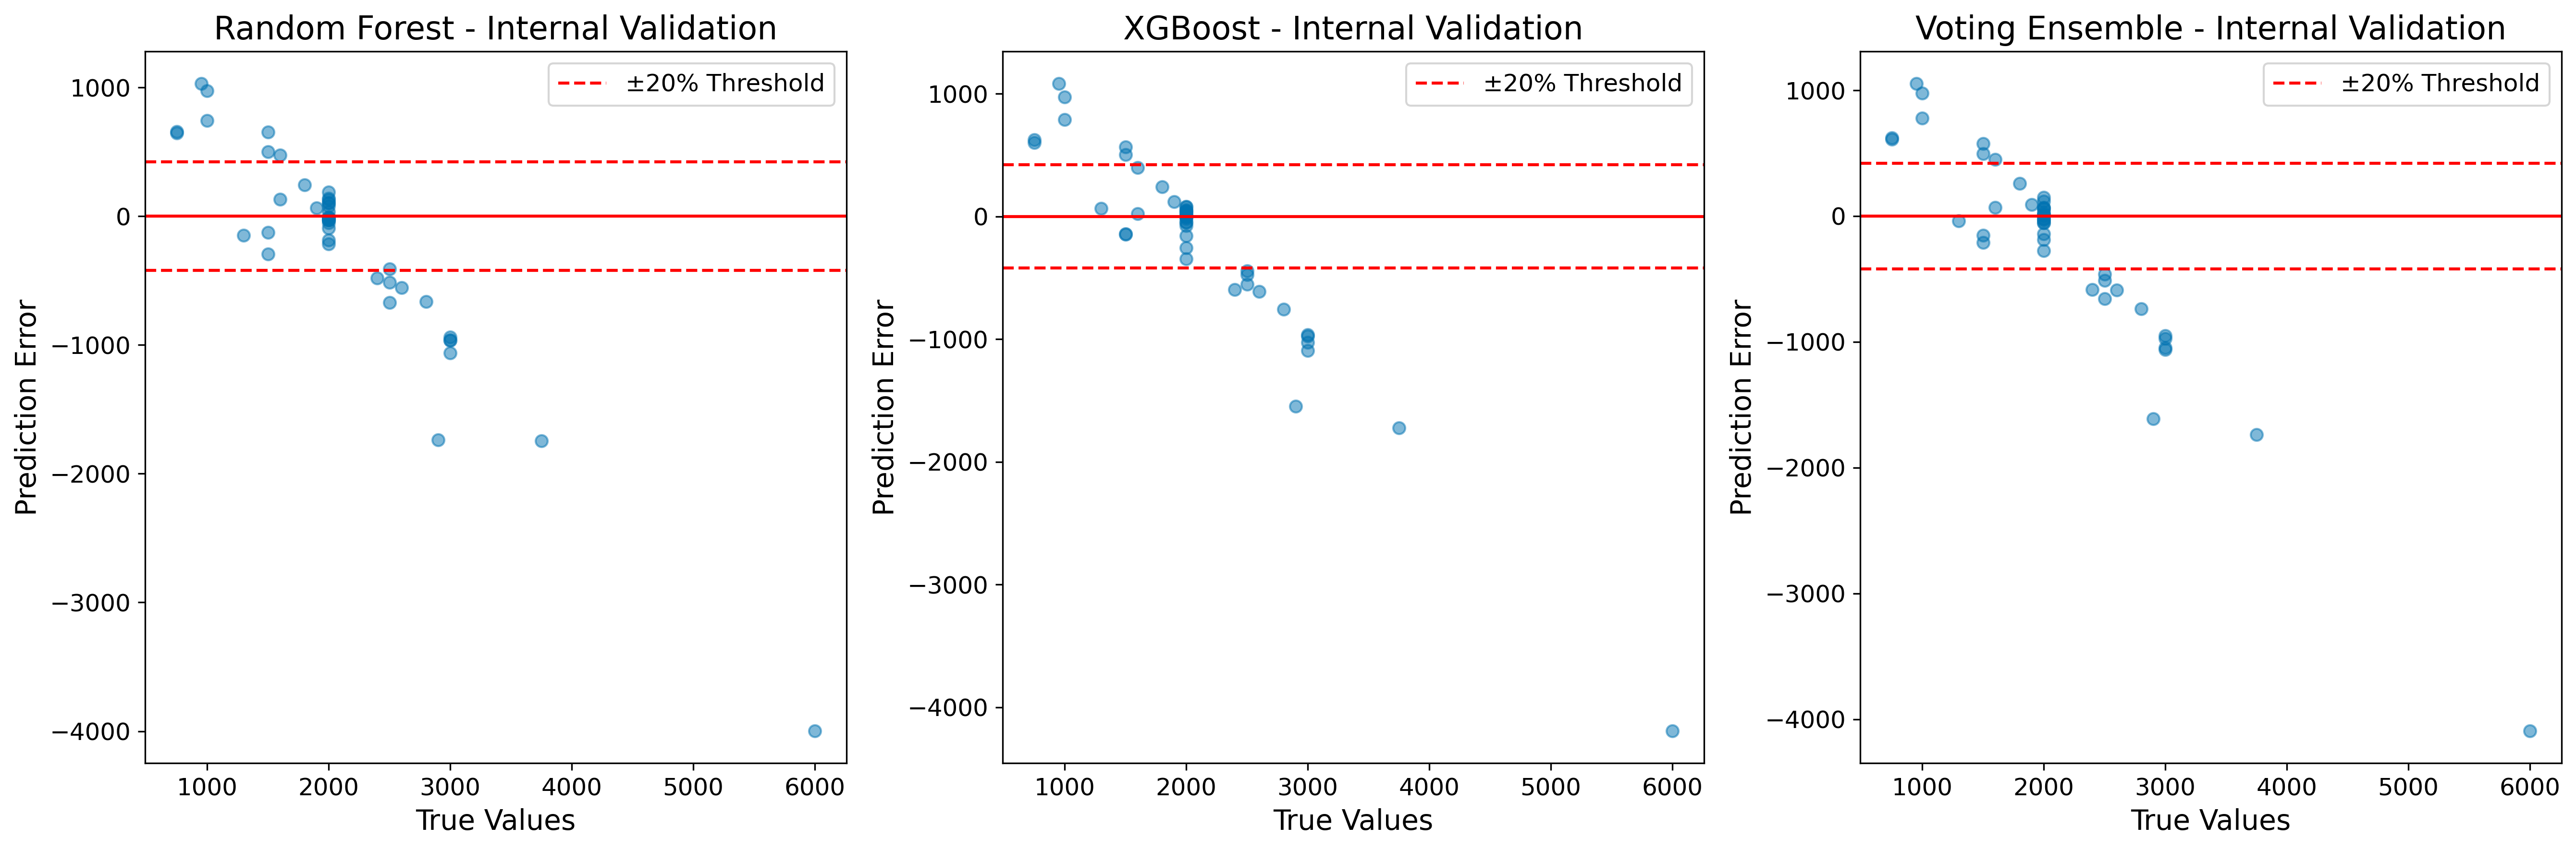

In [ ]:
# Define a helper function to calculate sorting priority
def get_priority_metrics(internal_results):
    return sorted(
        internal_results.items(),
        key=lambda x: (
            -x[1]["20% Accuracy"],  # Accuracy 우선 순위 (내림차순)
            x[1]["RMSE"]            # RMSE (오름차순)
        )
    )

# Get top 3 models based on accuracy and RMSE
top_3_internal_models = get_priority_metrics(internal_results)[:3]

# Convert top 3 models to predictions for visualization
top_3_internal_predictions = {
    model_name: internal_predictions[model_name]
    for model_name, _ in top_3_internal_models
}

# Visualize
visualize_internal_validation(
    y_internal=y_internal,
    internal_predictions=top_3_internal_predictions,
    save_path="top_3_internal_validation_results.png"
)


In [ ]:
files.download("top_3_internal_validation_results.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

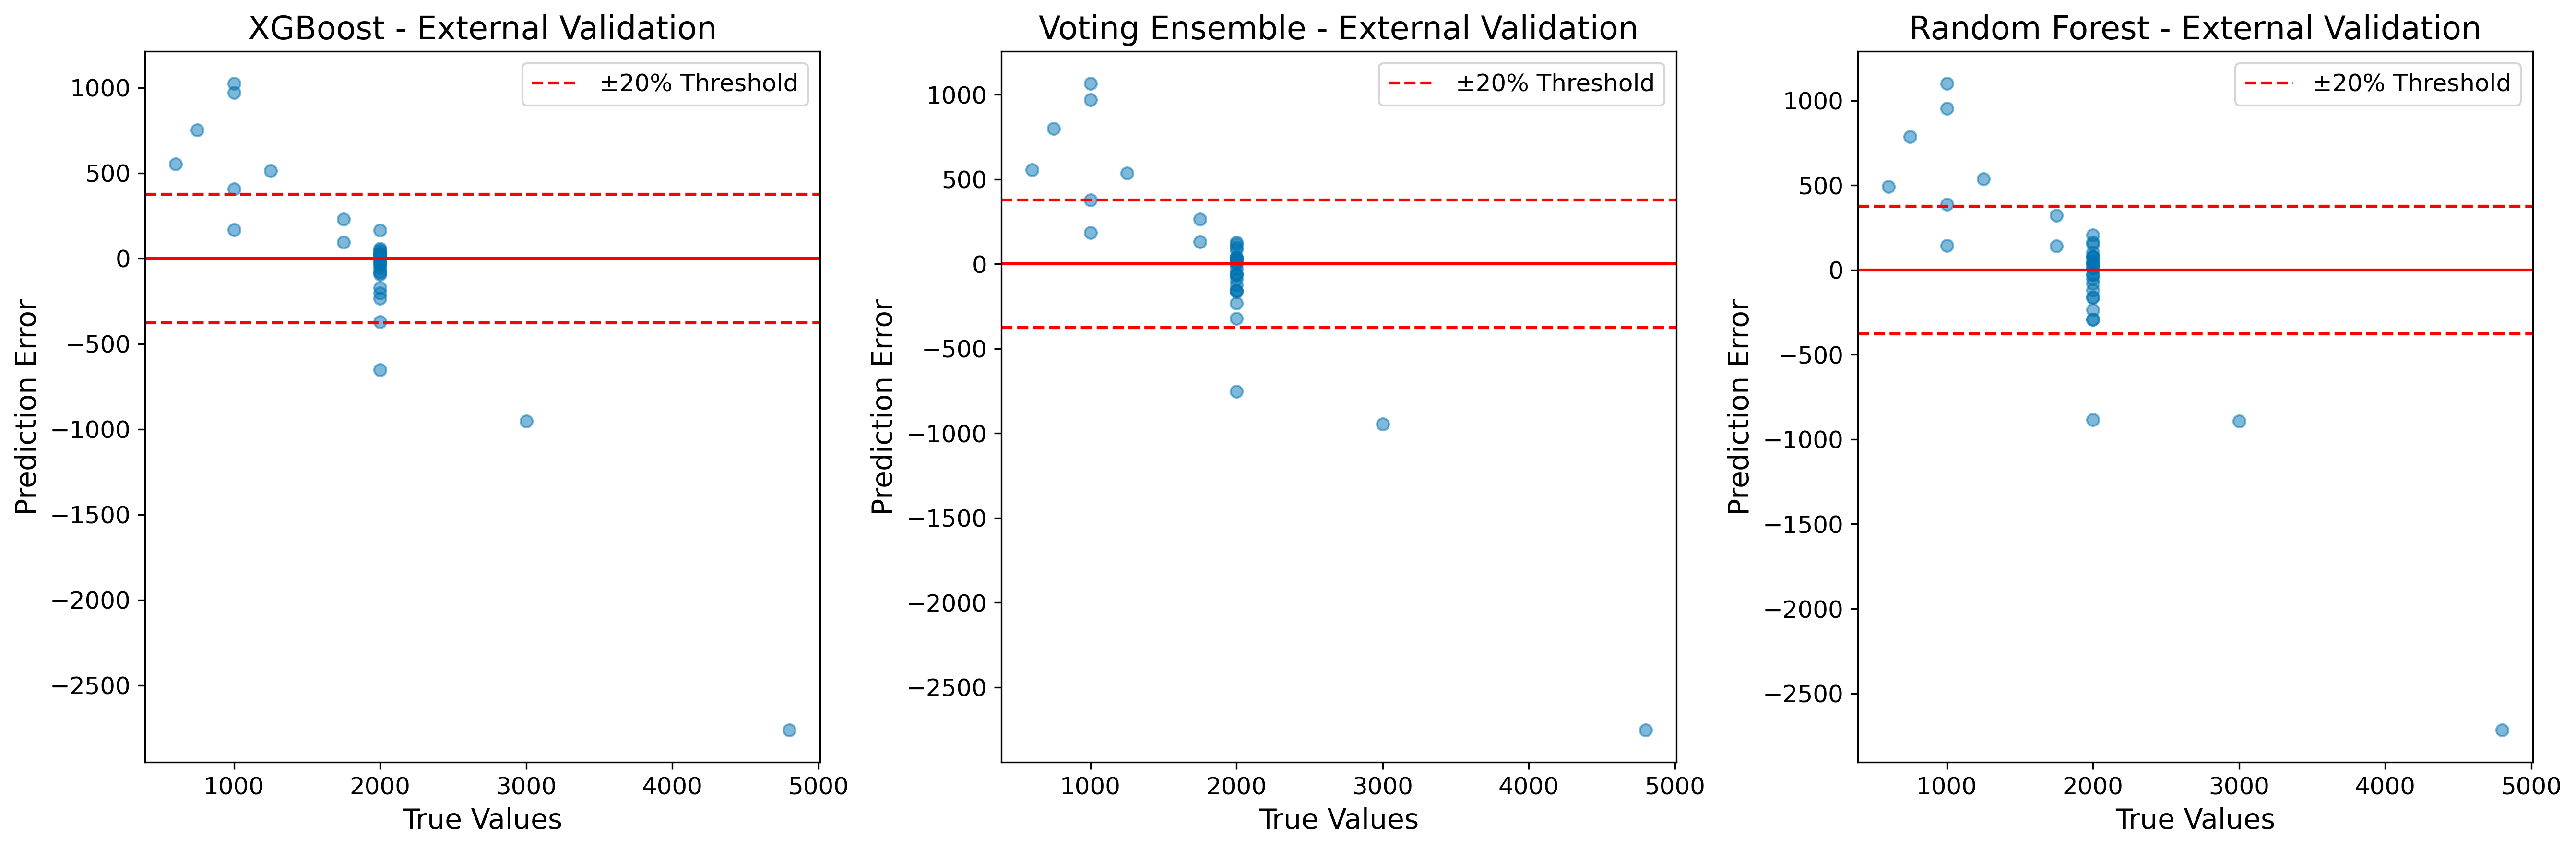

In [ ]:
# Define a helper function to calculate sorting priority
def get_priority_metrics(external_results):
    return sorted(
        external_results.items(),
        key=lambda x: (
            -x[1]["20% Accuracy"],  # Accuracy 우선 순위 (내림차순)
            x[1]["RMSE"]            # RMSE (오름차순)
        )
    )

# Get top 3 models based on accuracy and RMSE
top_3_external_models = get_priority_metrics(external_results)[:3]

# Convert top 3 models to predictions for visualization
top_3_external_predictions = {
    model_name: external_predictions[model_name]
    for model_name, _ in top_3_external_models
}

# Visualize
visualize_external_validation(
    y_external=y_external,
    external_predictions=top_3_external_predictions,
    save_path="top_3_external_validation_results.png"
)


In [ ]:
files.download("top_3_external_validation_results.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# #6 Summary of parameter

In [ ]:
# Extract best parameters for all models
optimal_parameters = []

for model_name, model_info in tuned_results.items():
    for param, value in model_info["Best Params"].items():
        optimal_parameters.append({
            "Model": model_name,
            "Parameter Name": param,
            "Best Value": value
        })

# Convert to a DataFrame for visualization
optimal_params_df = pd.DataFrame(optimal_parameters)

# Display the optimal parameters table
print("Optimal Parameters for All Models:")
print(optimal_params_df)

# Save the table as CSV for inclusion in supplementary material
optimal_params_df.to_csv("Optimal_Parameters_Table.csv", index=False)


Optimal Parameters for All Models:
            Model     Parameter Name Best Value
0   Random Forest       n_estimators        200
1   Random Forest  min_samples_split         10
2   Random Forest   min_samples_leaf          4
3   Random Forest          max_depth         10
4         XGBoost       n_estimators        200
5         XGBoost          max_depth          3
6         XGBoost      learning_rate       0.01
7        LightGBM       n_estimators        200
8        LightGBM          max_depth         -1
9        LightGBM      learning_rate       0.01
10       CatBoost       n_estimators        300
11       CatBoost      learning_rate       0.01
12    Extra Trees       n_estimators        300
13    Extra Trees  min_samples_split         10
14    Extra Trees          max_depth         20
15            SVR             kernel     linear
16            SVR              gamma      scale
17            SVR                  C         10


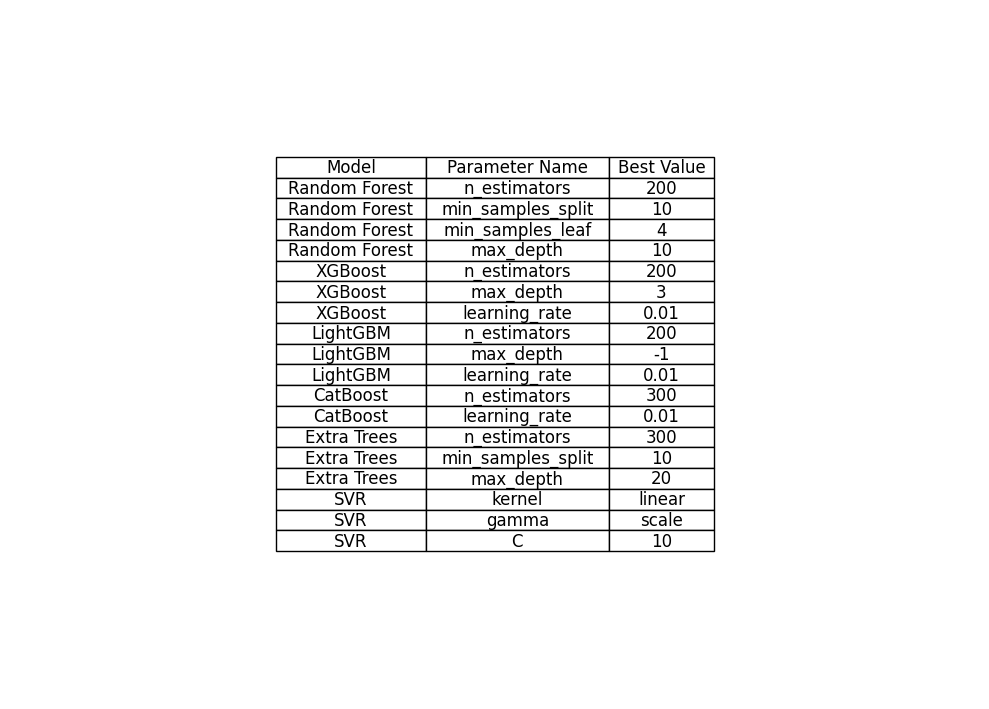

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define a function to create a table plot
def plot_table(dataframe, save_path="optimal_parameters_table.png"):
    fig, ax = plt.subplots(figsize=(10, len(dataframe) * 0.4))  # Adjust height dynamically
    ax.axis('off')  # Remove axes
    ax.axis('tight')  # Make table tight to fit content
    table = ax.table(
        cellText=dataframe.values,
        colLabels=dataframe.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.auto_set_column_width(col=list(range(len(dataframe.columns))))  # Adjust column width
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)  # Save the table as an image
    plt.show()

# Call the function to plot the table
plot_table(optimal_params_df, save_path="optimal_parameters_table.png")


In [ ]:
files.download("Optimal_Parameters_Table.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# #7 SHAP(SHapley Additive exPlanations) analysis

In [ ]:
xgb_model = tuned_results["XGBoost"]["Best Model"]

In [ ]:
# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)

In [ ]:
# Generate SHAP values for the external validation dataset
shap_values = explainer.shap_values(X_external)

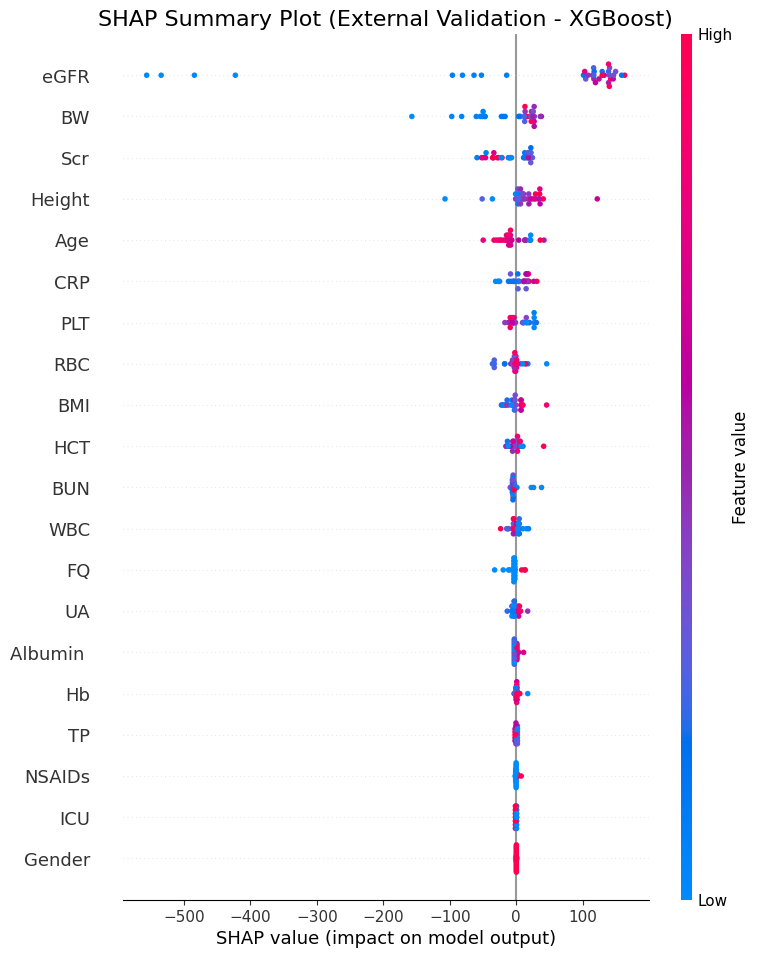

In [ ]:
# 1. SHAP Summary Plot with adjusted layout
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_external, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (External Validation - XGBoost)", fontsize=16)

# Save the plot with adjusted layout
plt.savefig("SHAP_Summary_XGBoost_External.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Download SHAP Summary Plot
files.download("SHAP_Summary_XGBoost_External.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 2. SHAP Bar Plot (Mean Absolute SHAP Values)
mean_shap_values = np.abs(shap_values).mean(axis=0)  # Mean absolute SHAP values
sorted_indices = np.argsort(mean_shap_values)[::-1]  # Sort features by importance
top_features = X_external.columns[sorted_indices][:10]  # Top 10 features

In [ ]:
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_external)

Global feature importance plot saved as 'external_xgb_global_feature_importance.png'


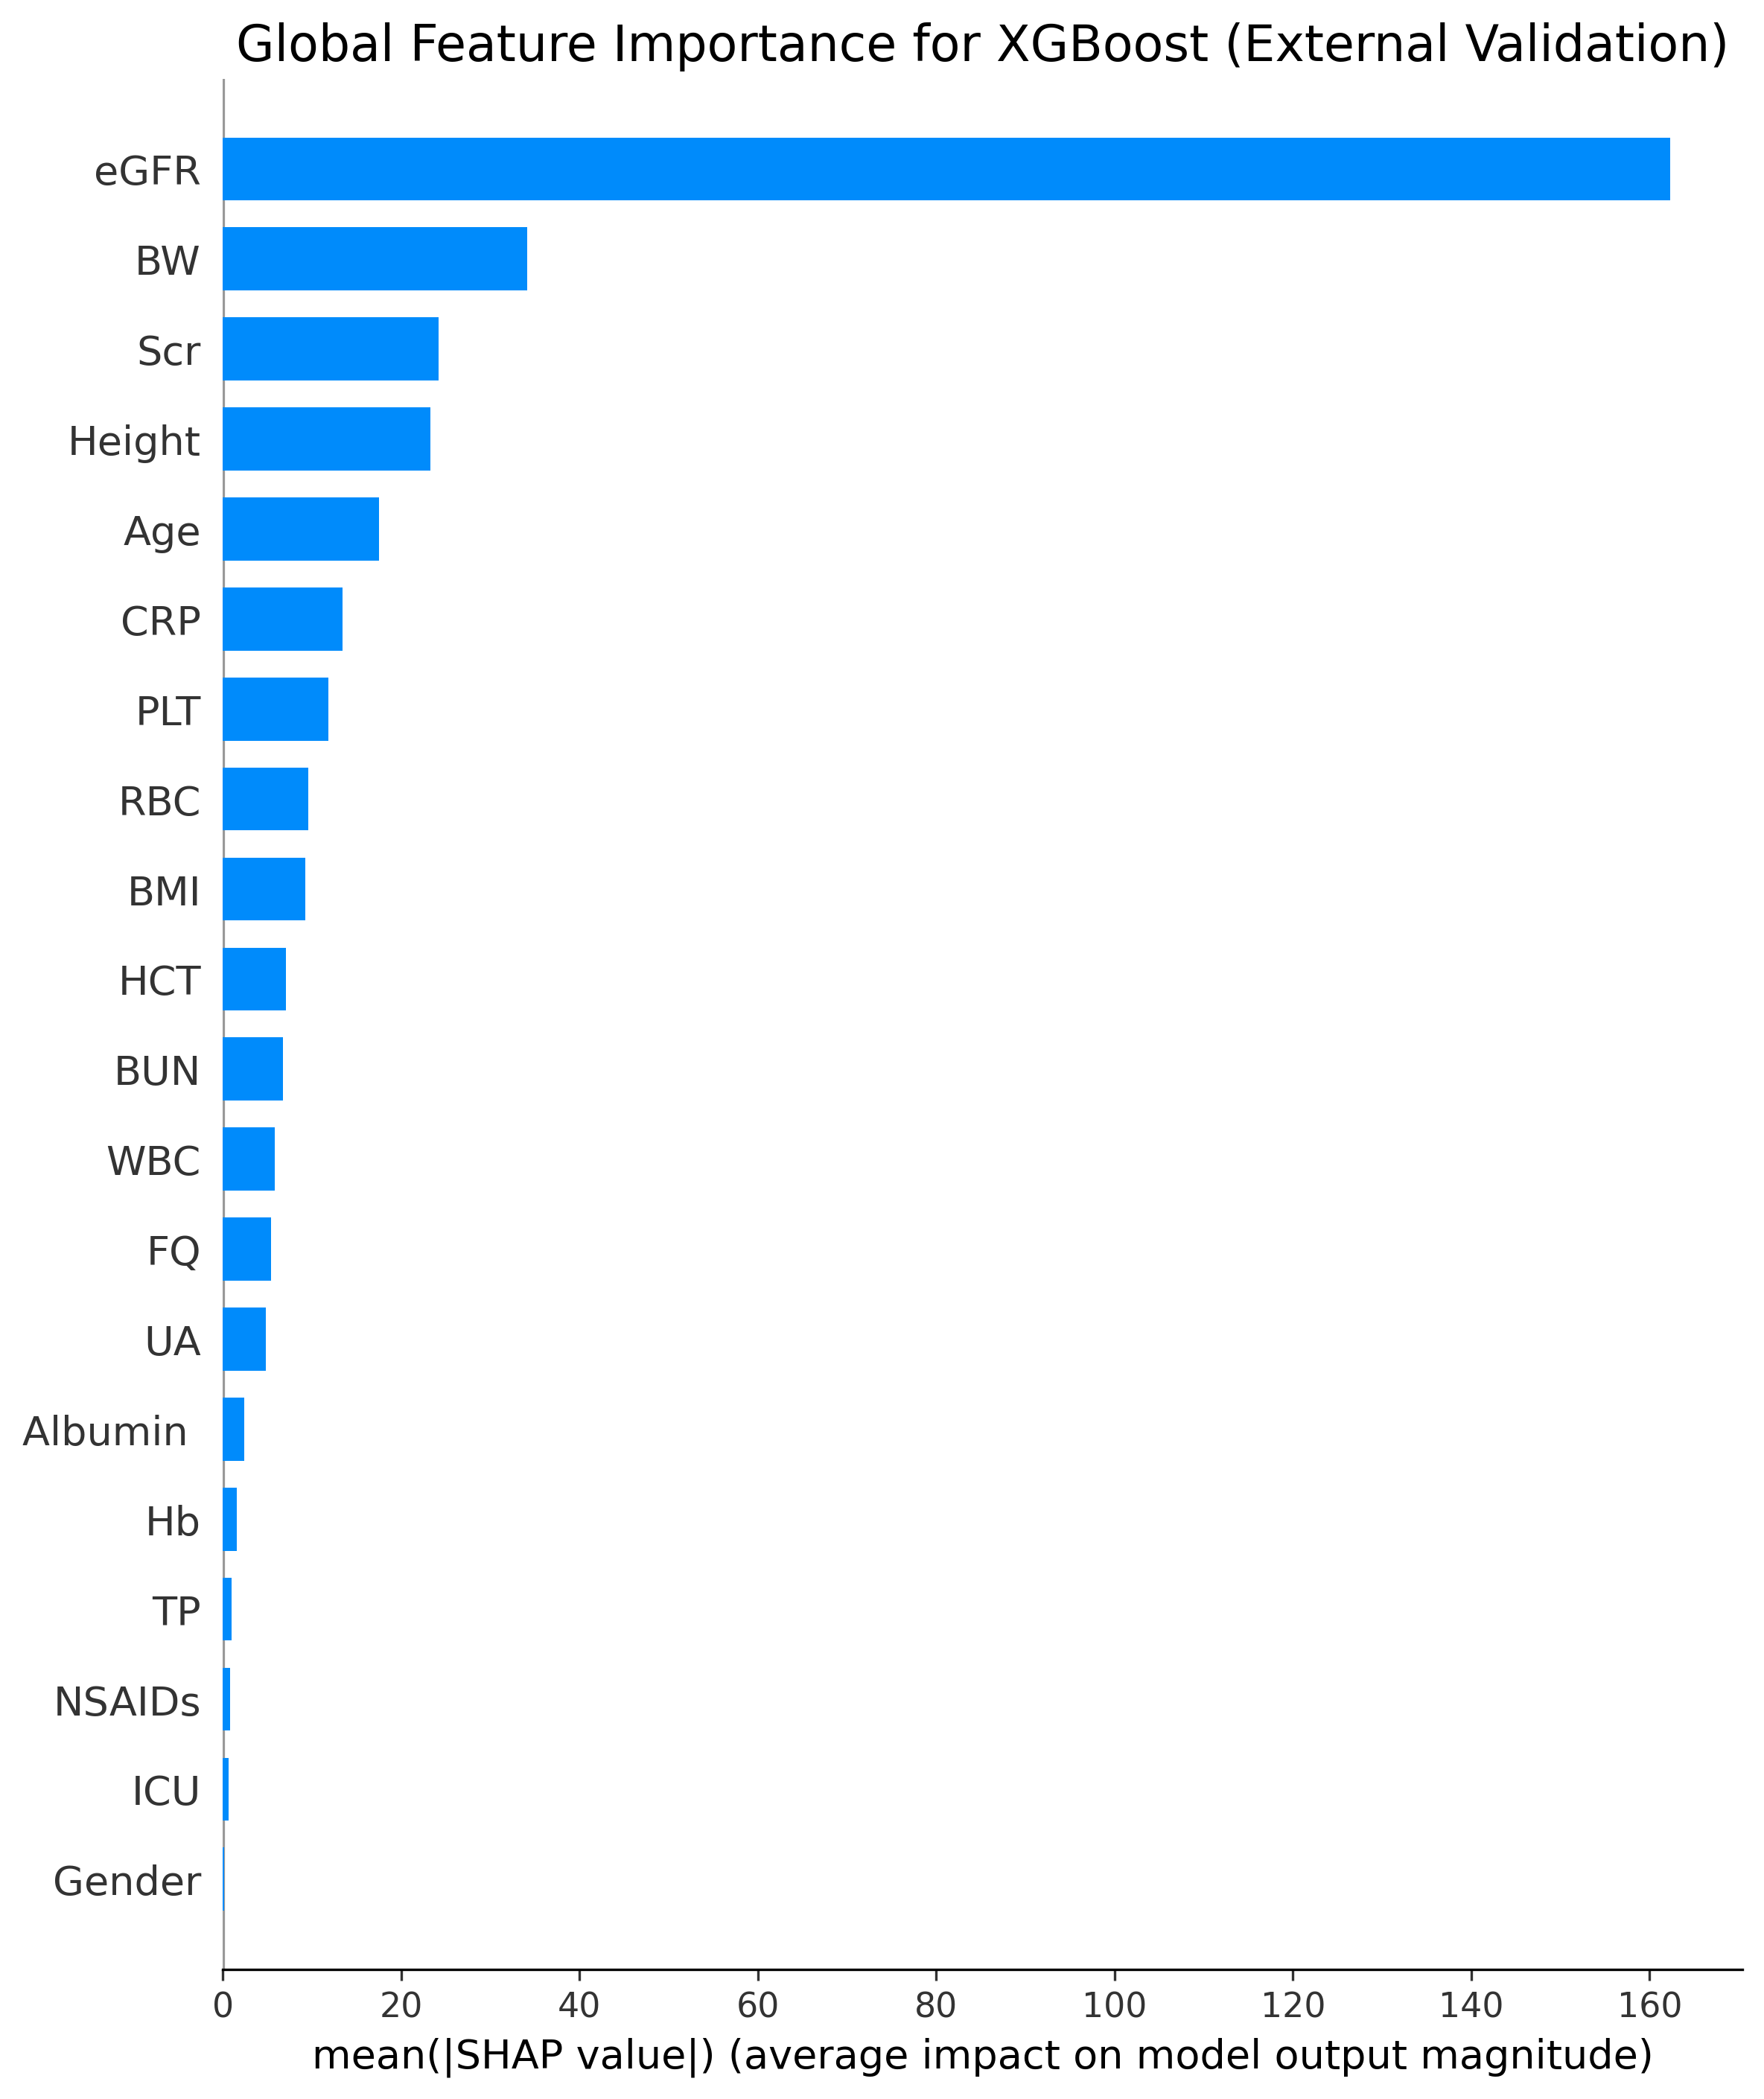

In [ ]:
# Create global feature importance plot
plt.figure(figsize=(10, 8), dpi=300)
shap.summary_plot(shap_values_xgb, X_external, plot_type="bar", show=False)
plt.title("Global Feature Importance for XGBoost (External Validation)", fontsize=16)
plt.tight_layout()
plt.savefig("external_xgb_global_feature_importance.png", dpi=300)
print("Global feature importance plot saved as 'external_xgb_global_feature_importance.png'")
plt.show()

In [ ]:
files.download("external_xgb_global_feature_importance.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download SHAP Bar Plot
files.download("external_xgb_global_feature_importance.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Global feature importance plot saved as 'internal_rf_global_feature_importance.png'


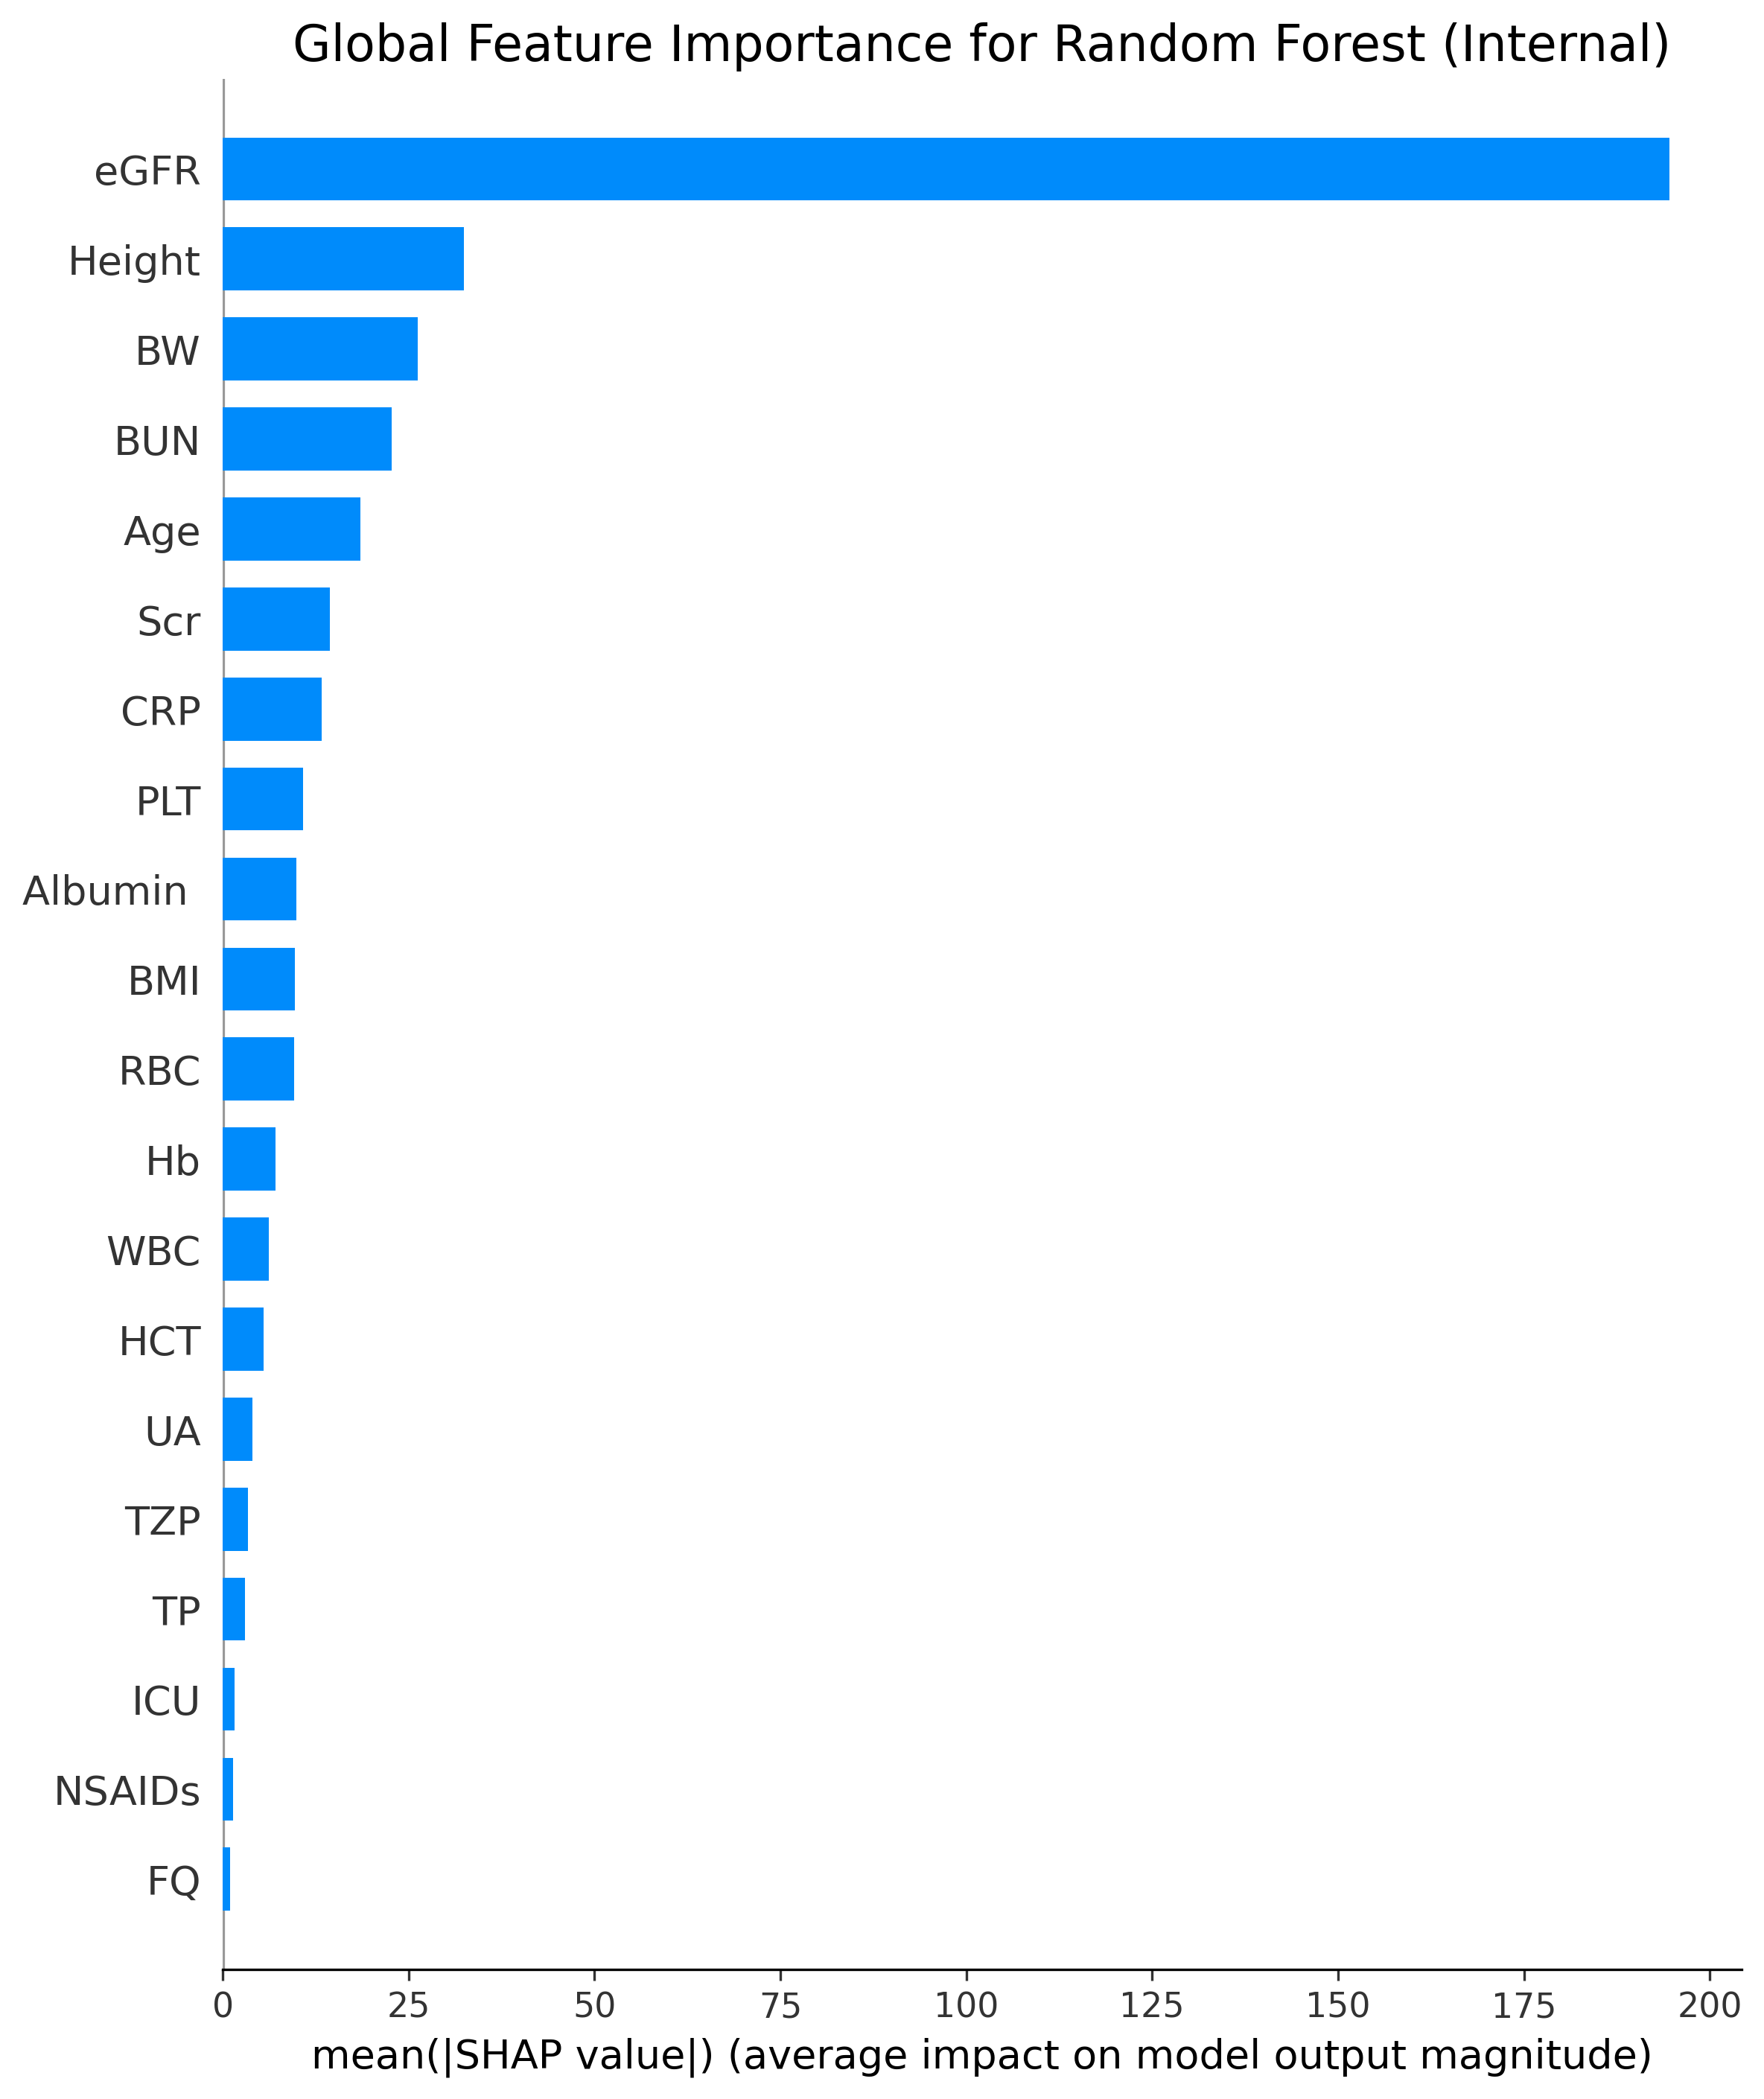

In [ ]:
# Load Random Forest model (best model from internal validation)
rf_internal_model = tuned_results["Random Forest"]["Best Model"]

# Explain the model using SHAP
explainer_rf = shap.TreeExplainer(rf_internal_model)
shap_values_rf = explainer_rf.shap_values(X_internal)

# Create global feature importance plot
plt.figure(figsize=(10, 8), dpi=300)
shap.summary_plot(shap_values_rf, X_internal, plot_type="bar", show=False)
plt.title("Global Feature Importance for Random Forest (Internal)", fontsize=16)
plt.tight_layout()
plt.savefig("internal_rf_global_feature_importance.png", dpi=300)
print("Global feature importance plot saved as 'internal_rf_global_feature_importance.png'")
plt.show()

SHAP summary plot saved as 'internal_rf_shap_summary_plot.png'


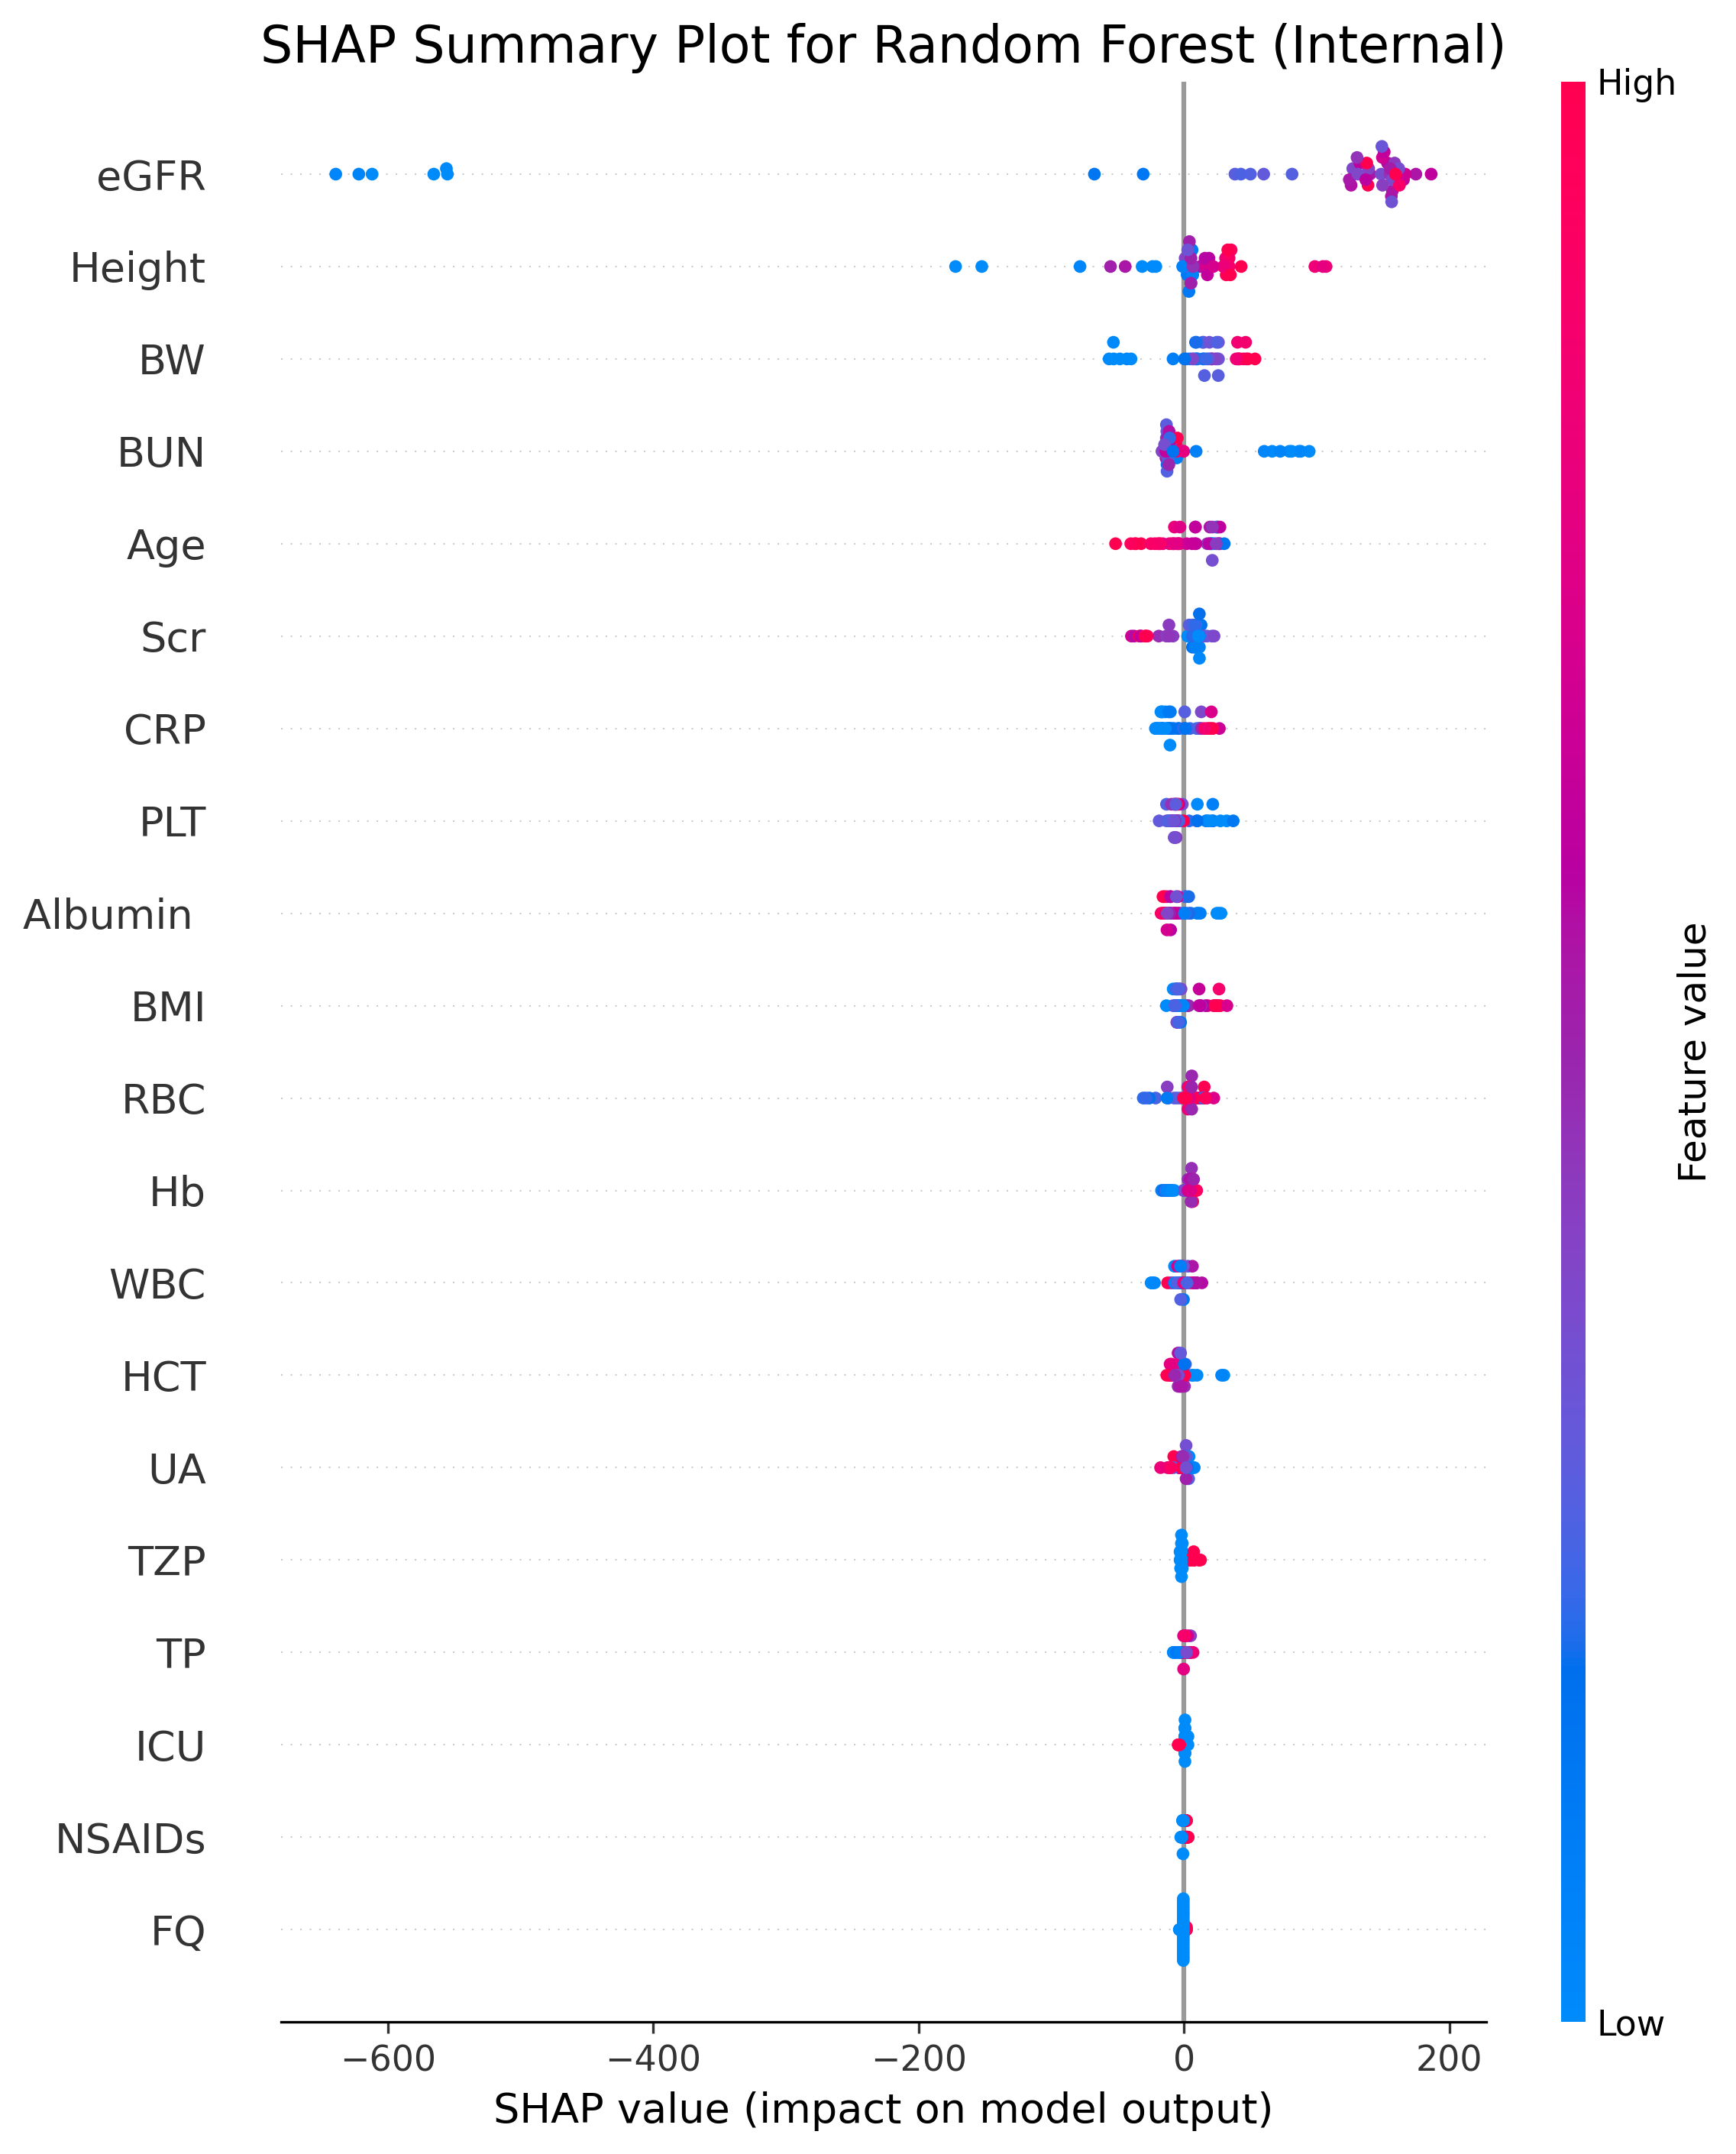

In [ ]:
# Create SHAP summary plot
plt.figure(figsize=(10, 8), dpi=300)
shap.summary_plot(shap_values_rf, X_internal, show=False)
plt.title("SHAP Summary Plot for Random Forest (Internal)", fontsize=16)
plt.tight_layout()
plt.savefig("internal_rf_shap_summary_plot.png", dpi=300)
print("SHAP summary plot saved as 'internal_rf_shap_summary_plot.png'")
plt.show()


In [ ]:
files.download("internal_rf_global_feature_importance.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("internal_rf_shap_summary_plot.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# #8 Supplemental Material - Distribution of Internal, external dataset

<ipython-input-76-7bffd50f5df9>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_internal[variable], ax=axs[row, col], order=[0, 1],
<ipython-input-76-7bffd50f5df9>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_internal[variable], ax=axs[row, col], order=[0, 1],
<ipython-input-76-7bffd50f5df9>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_internal[variable], ax=axs[row, col], order=[0, 1],
<ipython-input-76-7bffd50f5df9>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

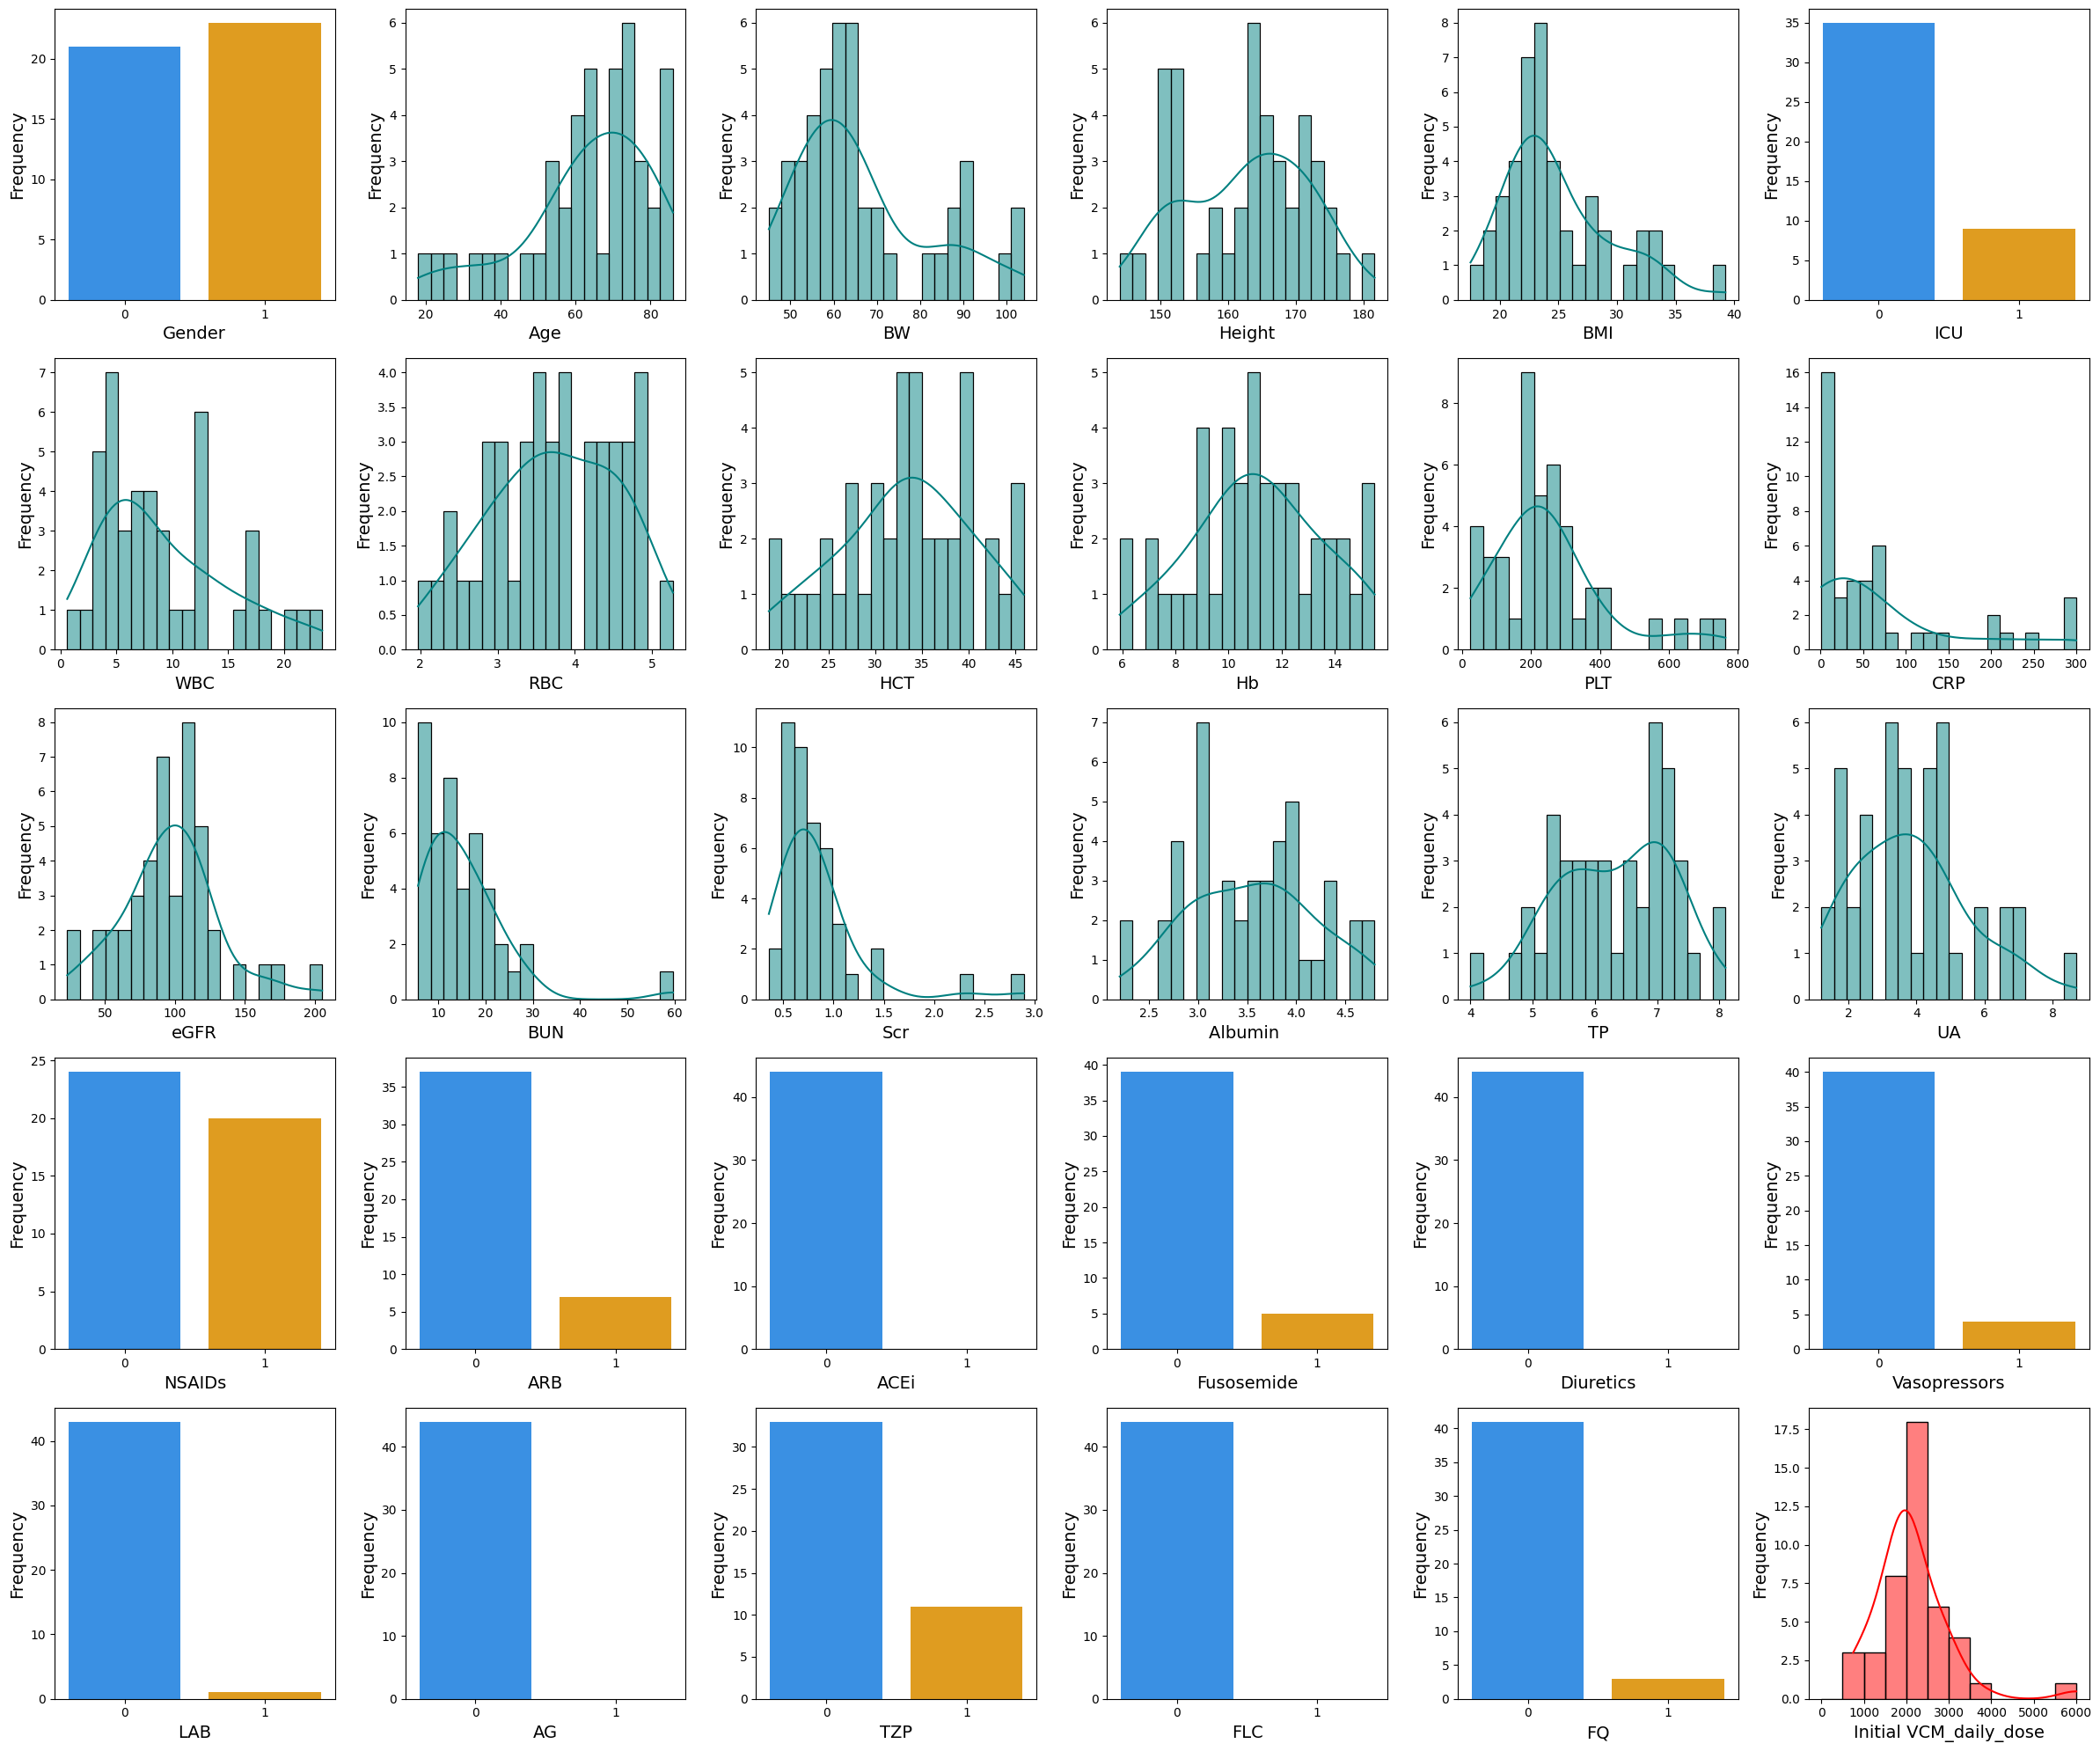

In [ ]:
# All variables and target column
all_variables = df_internal.columns
target_variable = 'Initial VCM_daily_dose'

# List of columns with binary values
binary_columns = ['Gender', 'ICU', 'NSAIDs', 'ARB', 'ACEi', 'Fusosemide',
                  'Diuretics', 'Vasopressors', 'LAB', 'AG', 'TZP', 'FLC', 'FQ']

# Validate binary columns
binary_columns = [col for col in binary_columns if col in df_internal.columns]

# Determine rows and columns dynamically
num_cols = 6
num_rows = (len(all_variables) + num_cols - 1) // num_cols  # Ceiling division

# Set up figure dynamically
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
sns.set_palette('colorblind')

# Plot each variable
for i, variable in enumerate(all_variables):
    row = i // num_cols
    col = i % num_cols
    if variable == target_variable:
        sns.histplot(df_internal[variable], kde=True, color='red',
                     ax=axs[row, col], binrange=(0, df_internal[variable].max()))
    elif variable in binary_columns:
        sns.countplot(x=df_internal[variable], ax=axs[row, col], order=[0, 1],
                      palette=['dodgerblue', 'orange'])
    else:
        sns.histplot(df_internal[variable], kde=True, ax=axs[row, col], bins=20, color='teal')
    axs[row, col].set_xlabel(variable, fontsize=14)
    axs[row, col].set_ylabel('Frequency', fontsize=14)

# Remove unused subplots
for j in range(len(all_variables), num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()

# Save the figure with appropriate resolution
plt.savefig('Distributions_of_internal_variables.png', dpi=300)

# Download the figure for convenience
from google.colab import files
files.download('Distributions_of_internal_variables.png')


<ipython-input-77-97d7df41921e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_external[variable], ax=axs[row, col], order=[0, 1],
<ipython-input-77-97d7df41921e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_external[variable], ax=axs[row, col], order=[0, 1],
<ipython-input-77-97d7df41921e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_external[variable], ax=axs[row, col], order=[0, 1],
<ipython-input-77-97d7df41921e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

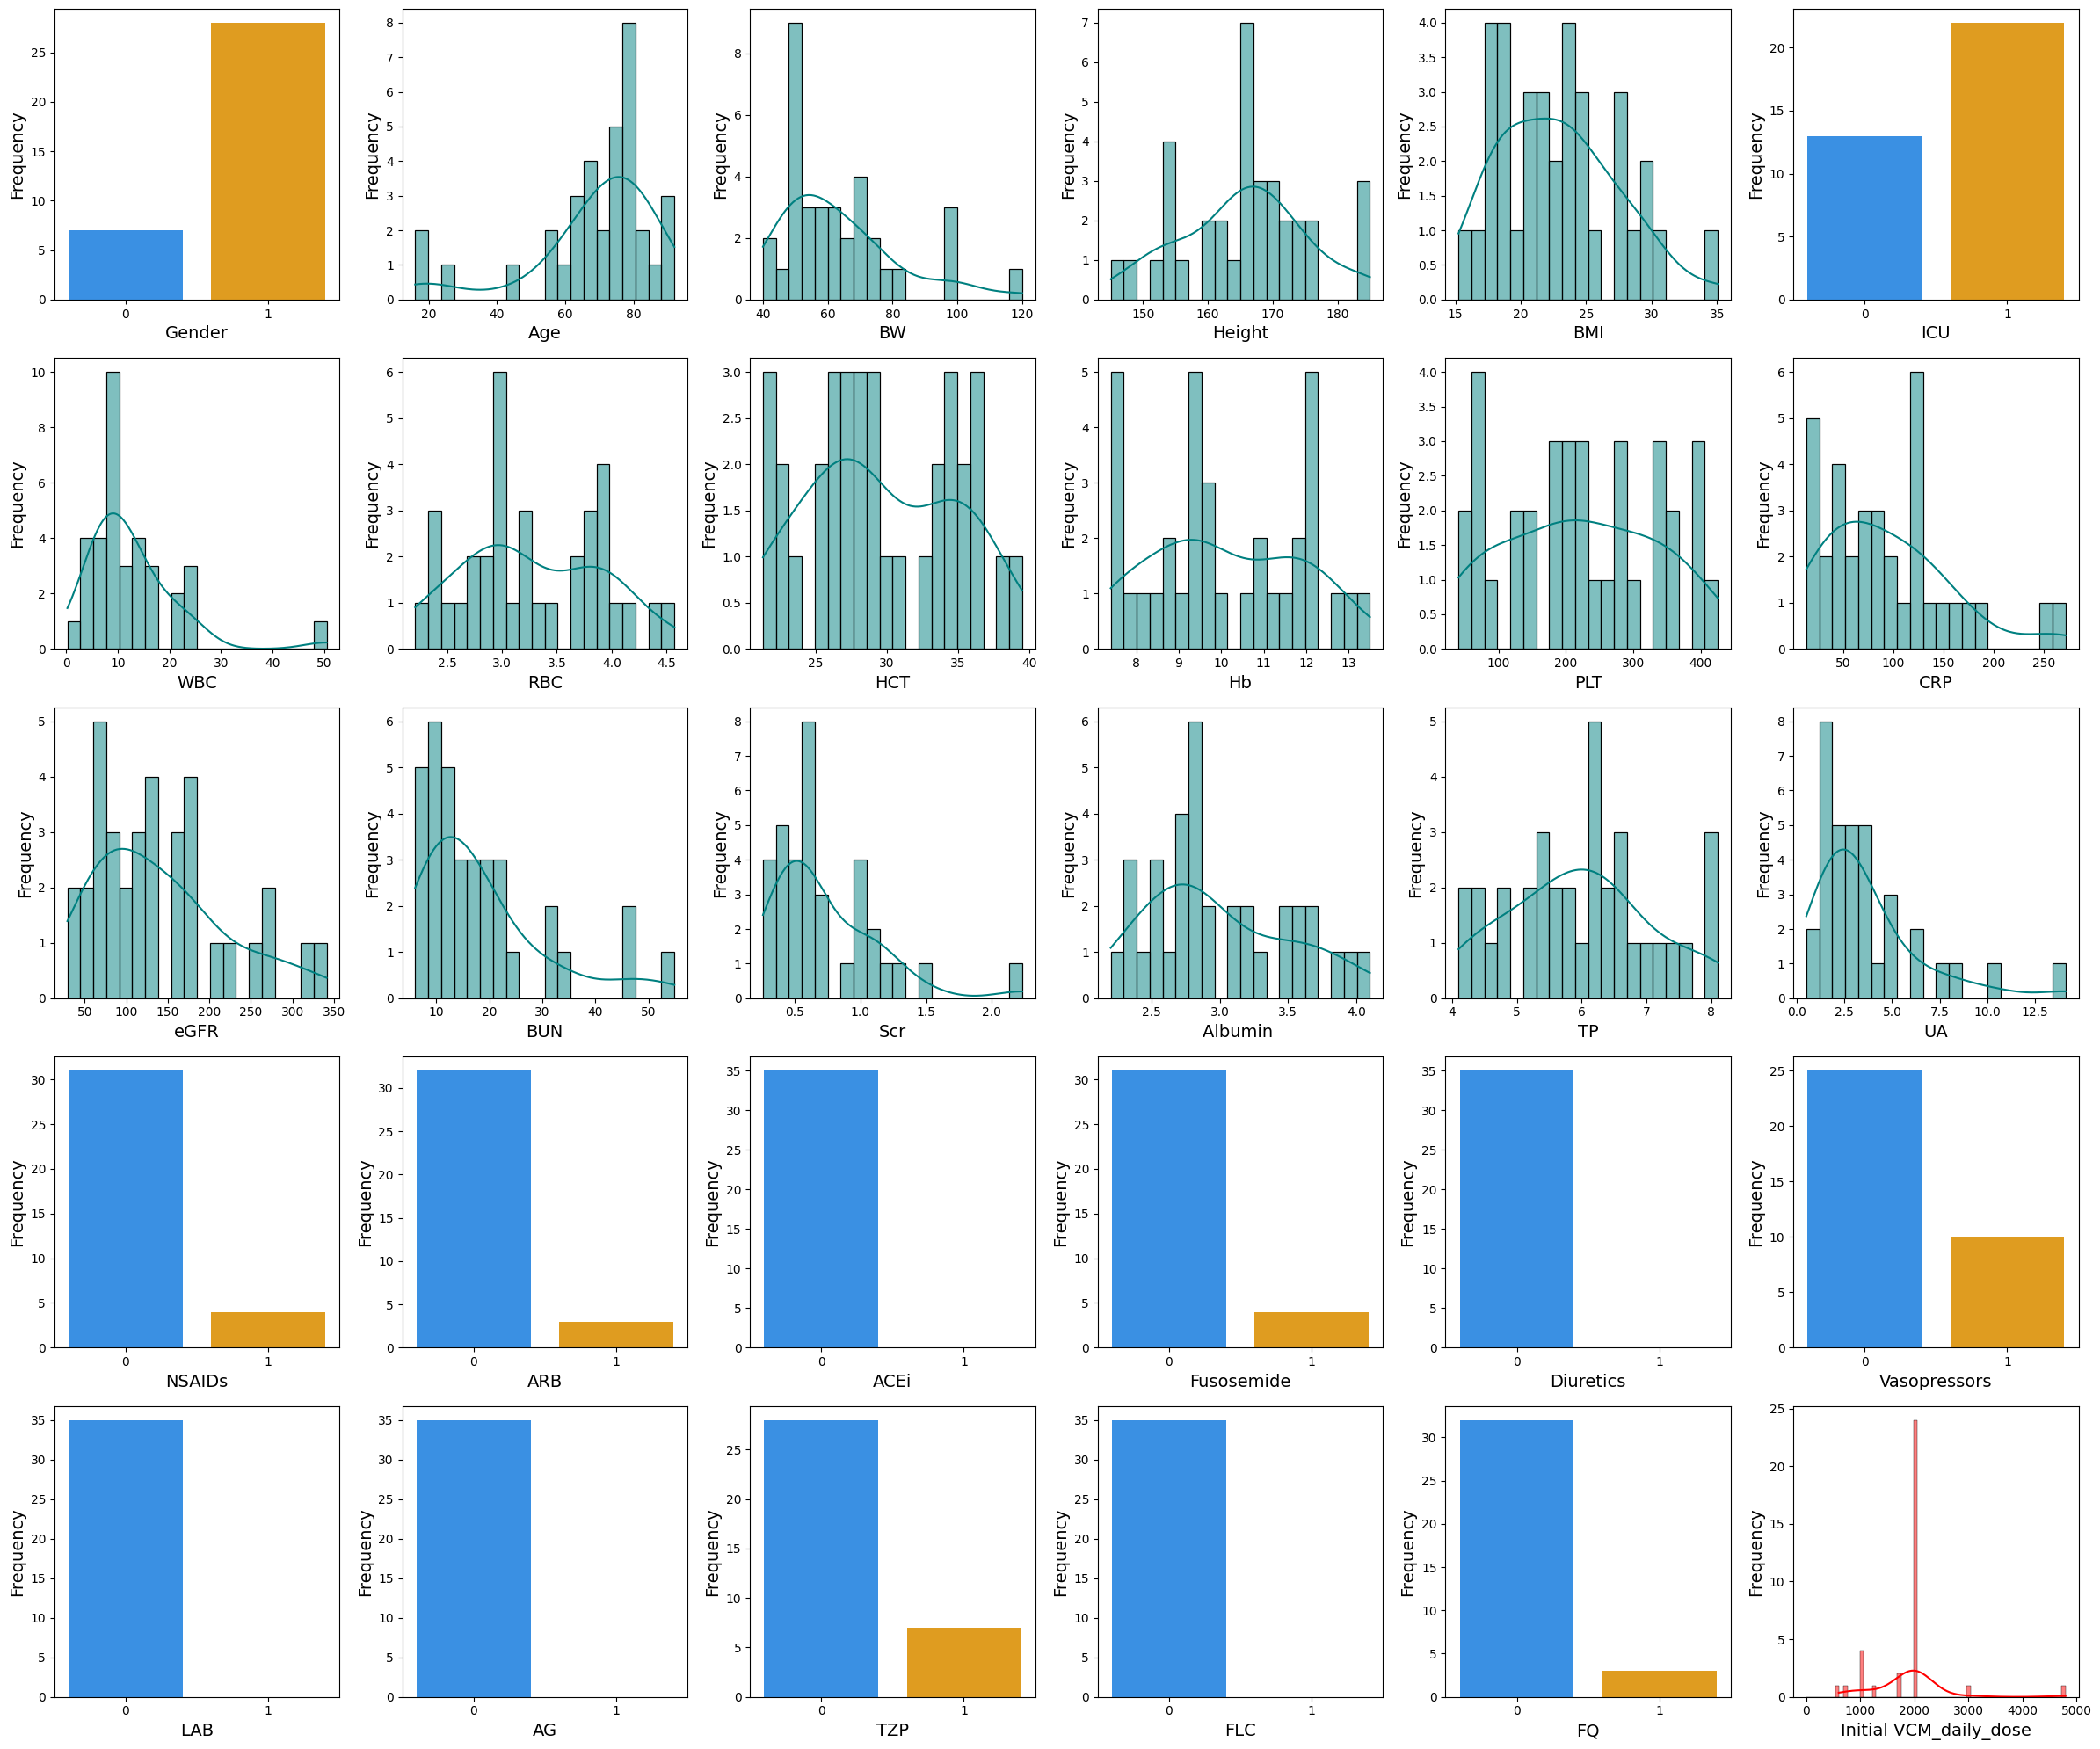

In [ ]:
# All variables and target column
all_variables = df_external.columns
target_variable = 'Initial VCM_daily_dose'

# List of columns with binary values
binary_columns = ['Gender', 'ICU', 'NSAIDs', 'ARB', 'ACEi', 'Fusosemide',
                  'Diuretics', 'Vasopressors', 'LAB', 'AG', 'TZP', 'FLC', 'FQ']

# Validate binary columns
binary_columns = [col for col in binary_columns if col in df_external.columns]

# Determine rows and columns dynamically
num_cols = 6
num_rows = (len(all_variables) + num_cols - 1) // num_cols  # Ceiling division

# Set up figure dynamically
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
sns.set_palette('colorblind')

# Plot each variable
for i, variable in enumerate(all_variables):
    row = i // num_cols
    col = i % num_cols
    if variable == target_variable:
        sns.histplot(df_external[variable], kde=True, color='red',
                     ax=axs[row, col], binrange=(0, df_external[variable].max()))
    elif variable in binary_columns:
        sns.countplot(x=df_external[variable], ax=axs[row, col], order=[0, 1],
                      palette=['dodgerblue', 'orange'])
    else:
        sns.histplot(df_external[variable], kde=True, ax=axs[row, col], bins=20, color='teal')
    axs[row, col].set_xlabel(variable, fontsize=14)
    axs[row, col].set_ylabel('Frequency', fontsize=14)

# Remove unused subplots
for j in range(len(all_variables), num_rows * num_cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()

# Save the figure with appropriate resolution
plt.savefig('Distributions_of_external_variables.png', dpi=300)

# Download the figure for convenience
from google.colab import files
files.download('Distributions_of_external_variables.png')
